### Task

Analysis of the climate context that informs our FWI results (patterns in T, RH etc.)
    
At least 4 figures, inclusive of spread of the models


##### Importing modules

In [1]:
import xarray
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import warnings
import matplotlib as mpl
import warnings

##### Defining Region Masks

In [2]:
# 0 = Whole UK
# 1 = East Midlands
# 2 = East of England
# 3 = East Scotland
# 4 = London
# 5 = North-East England
# 6 = North Scotland
# 7 = North-West England
# 8 = South-East England
# 9 = South-West England
# 10 = West Midlands
# 11 = West Scotland
# 12 = Yorkshire and Humberside
# 13 = Channel Islands?
# 14 = Isle of Man?
# 15 = Northern Ireland
# 16 = Wales

##### Loading cordex data

In [2]:
def get_cordex_addresses():
    models = pd.read_csv('cordex_models.txt', sep='\t')

    # Getting file strings:
        # Directories:
    root = '/data/met/ukcordex/'
    directories = [root + models['GCM'][i] + '/' +
                   models['RCM'][i] + '/' +
                   models['Ensemble'][i] + '/dmo/'
                   for i in range(models.shape[0])]

        # Filenames:
    #feat. clunky for loops and error handling!
    tas_files  = []
    hurs_files = []
    pr_files   = []
    wind_files = []
    err_indexs = []
    print(type(err_indexs))
    for i in range(models.shape[0]):
        try:
            for f_name in os.listdir(directories[i]):
                if f_name.startswith('tas_'):
                    tas_files.append(str(f_name))
                if f_name.startswith('hurs_'):
                    hurs_files.append(str(f_name))
                if f_name.startswith('sfcWind_'):
                    wind_files.append(str(f_name))
                if f_name.startswith('pr_'):
                    pr_files.append(str(f_name))

        except OSError as error:
            print(f'Inelligible directory at: {directories[i]}')
            err_indexs.append(int(i))


    for i in range(len(err_indexs)):
        del directories[err_indexs[i]]
    
    return directories,tas_files,hurs_files,wind_files,pr_files

def earth_radius(lat):
    # From: https://towardsdatascience.com/the-correct-way-to-average-the-globe-92ceecd172b7
    a = 6378137
    b = 6356752.3142
    e2 = 1 - (b**2/a**2)
    lat = np.deg2rad(lat)
    lat_gc = np.arctan( (1-e2)*np.tan(lat) )

    # radius equation
    # see equation 3-107 in WGS84
    r = (
        (a * (1 - e2)**0.5) 
         / (1 - (e2 * np.cos(lat_gc)**2))**0.5 
        )

    return r


def area_grid(lats,lons):
    # Adapted rom: https://towardsdatascience.com/the-correct-way-to-average-the-globe-92ceecd172b7
    R = earth_radius(lats)
    dlat = np.deg2rad(np.gradient(lats, axis=0))
    dlon = np.deg2rad(np.gradient(lons, axis=1))
    dy = dlat * R
    dx = dlon * R * np.cos(np.deg2rad(lats))
    area_weights = dy * dx
    
    return area_weights

##### Building the data-sets - do not re-run

In [ ]:
# Code Plan

# 1) Loop acriss models and regions
# 2) Get list mean annual values for each model and region and variable
# 3) Save array
# 3) Make plot (cornflower blue and indian red)

In [3]:
directories,tas_files,hurs_files,wind_files,pr_files = get_cordex_addresses()
i = 5
tas_data  = xarray.open_dataset(directories[i] + tas_files[i], engine = "netcdf4")
try: #If datetime
    years = np.array(pd.to_datetime(np.array(tas_data.time)).year)
    months = np.array(pd.to_datetime(np.array(tas_data.time)).month)
except:
    years = np.vectorize(lambda x: x.year) (np.array(tas_data.time))
    months = np.vectorize(lambda x: x.month) (np.array(tas_data.time))   

indices = [0]*100
for k in range(1981,2081): # years
    year_inds = np.where(years == k)
    summer_inds=np.concatenate((np.where(months == 6)[0],np.where(months == 7)[0],np.where(months == 8)[0]),axis = 0)
    inds = np.intersect1d(year_inds,summer_inds)
    indices[k-1981] = inds
    
print(indices[99])

<class 'list'>
[36342 36343 36344 36345 36346 36347 36348 36349 36350 36351 36352 36353
 36354 36355 36356 36357 36358 36359 36360 36361 36362 36363 36364 36365
 36366 36367 36368 36369 36370 36371 36372 36373 36374 36375 36376 36377
 36378 36379 36380 36381 36382 36383 36384 36385 36386 36387 36388 36389
 36390 36391 36392 36393 36394 36395 36396 36397 36398 36399 36400 36401
 36402 36403 36404 36405 36406 36407 36408 36409 36410 36411 36412 36413
 36414 36415 36416 36417 36418 36419 36420 36421 36422 36423 36424 36425
 36426 36427 36428 36429 36430 36431 36432 36433]


In [4]:
mask = np.zeros((100,100))
np.array([mask]*100).shape

(100, 100, 100)

In [6]:
region_data  = xarray.open_dataset('/home/theo/data/ukcp18-uk-land-region-rll.nc')
region_mask = region_data.admin_region
region_mask = np.nan_to_num(region_mask)
directories,tas_files,hurs_files,wind_files,pr_files = get_cordex_addresses()

for i in range(20,len(directories)): # files
    print(f'Model {i+1} of {len(directories)}')
    # Loading data
    tas_data  = xarray.open_dataset(directories[i] + tas_files[i], engine = "netcdf4")
    temperature = np.array(tas_data.tas[:,:,:]) - 273.15
    hurs_data  = xarray.open_dataset(directories[i] + hurs_files[i], engine = "netcdf4")
    r_hum = np.array(hurs_data.hurs[:,:,:])
    wind_data  = xarray.open_dataset(directories[i] + wind_files[i], engine = "netcdf4")
    wind = np.array(wind_data.sfcWind[:,:,:])*3.6
    pr_data  = xarray.open_dataset(directories[i] + pr_files[i], engine = "netcdf4")
    rain = np.array(pr_data.pr[:,:,:])*86400
    
    try: #If datetime
        years = np.array(pd.to_datetime(np.array(tas_data.time)).year)
        months = np.array(pd.to_datetime(np.array(tas_data.time)).month)
    except:
        years = np.vectorize(lambda x: x.year) (np.array(tas_data.time))
        months = np.vectorize(lambda x: x.month) (np.array(tas_data.time))    
    
    try:
        lats = np.array(tas_data.latitude)
        lons = np.array(tas_data.longitude)
    except:
        lats = np.array(tas_data.lat)
        lons = np.array(tas_data.lon)
    lons = np.where(lons < 180, lons, lons-360)
    weights = area_grid(lats,lons)/np.mean(area_grid(lats,lons))
    
    del tas_data,hurs_data,wind_data,pr_data,lats,lons
    
    indices = [0]*100
    for k in range(1981,2081): # years
        year_inds = np.where(years == k)
        summer_inds=np.concatenate((np.where(months == 6)[0],np.where(months == 7)[0],np.where(months == 8)[0]),axis = 0)
        inds = np.intersect1d(year_inds,summer_inds)
        indices[k-1981] = inds
        del inds,year_inds,summer_inds
    
    for j in range(17): # regions
        print(f'Region {j} of 16')
        # Masking data:
        if j == 0:
            mask = np.logical_not(region_mask == 0).astype(float)
            mask = mask*weights
            #mask[mask == 0] = np.nan
            #mask = mask / (np.nansum(mask))
        else:
            mask = (region_mask == j).astype(float)
            mask = mask*weights
            #mask[mask == 0] = np.nan
            #mask = mask / (np.nansum(mask))

        masked_temp = np.einsum('ijk,jk->ijk', temperature, mask)
        masked_rhum = np.einsum('ijk,jk->ijk', r_hum, mask)
        masked_wind = np.einsum('ijk,jk->ijk', wind, mask)
        masked_rain = np.einsum('ijk,jk->ijk', rain, mask)
        
        tas_arr  = np.array([])
        hurs_arr = np.array([])
        wind_arr = np.array([])
        pr_arr   = np.array([])


        tas_arr =  [np.average(masked_temp[indices[k],:,:],weights=np.array([mask]*len(indices[k]))) for k in range(100)]
        hurs_arr = [np.average(masked_rhum[indices[k],:,:],weights=np.array([mask]*len(indices[k]))) for k in range(100)]
        wind_arr = [np.average(masked_wind[indices[k],:,:],weights=np.array([mask]*len(indices[k]))) for k in range(100)]
        pr_arr =   [np.average(masked_rain[indices[k],:,:],weights=np.array([mask]*len(indices[k]))) for k in range(100)]
    
        del masked_temp,masked_rhum,masked_wind,masked_rain,mask

        np.save(f'/home/theo/outdata/01_data/tas_model_{i+1}_region_{j}_summer', tas_arr)
        np.save(f'/home/theo/outdata/01_data/hurs_model_{i+1}_region_{j}_summer', hurs_arr)
        np.save(f'/home/theo/outdata/01_data/wind_model_{i+1}_region_{j}_summer', wind_arr)
        np.save(f'/home/theo/outdata/01_data/pr_model_{i+1}_region_{j}_summer', pr_arr)
    del weights,temperature,r_hum,wind,rain

<class 'list'>
Model 21 of 49
Region 0 of 16
Region 1 of 16
Region 2 of 16
Region 3 of 16
Region 4 of 16
Region 5 of 16
Region 6 of 16
Region 7 of 16
Region 8 of 16
Region 9 of 16
Region 10 of 16
Region 11 of 16
Region 12 of 16
Region 13 of 16
Region 14 of 16
Region 15 of 16
Region 16 of 16
Model 22 of 49
Region 0 of 16
Region 1 of 16
Region 2 of 16
Region 3 of 16
Region 4 of 16
Region 5 of 16
Region 6 of 16
Region 7 of 16
Region 8 of 16
Region 9 of 16
Region 10 of 16
Region 11 of 16
Region 12 of 16
Region 13 of 16
Region 14 of 16
Region 15 of 16
Region 16 of 16
Model 23 of 49
Region 0 of 16
Region 1 of 16
Region 2 of 16
Region 3 of 16
Region 4 of 16
Region 5 of 16
Region 6 of 16
Region 7 of 16
Region 8 of 16
Region 9 of 16
Region 10 of 16
Region 11 of 16
Region 12 of 16
Region 13 of 16
Region 14 of 16
Region 15 of 16
Region 16 of 16
Model 24 of 49
Region 0 of 16
Region 1 of 16
Region 2 of 16
Region 3 of 16
Region 4 of 16
Region 5 of 16
Region 6 of 16
Region 7 of 16
Region 8 of 16
Regi

In [113]:
def ith_hurs(i,directories,hurs_files):
    hurs_data  = xarray.open_dataset(directories[i] + hurs_files[i], engine = "netcdf4")
    r_hum = np.array(hurs_data.hurs[:,:,:])
    return r_hum

r_hum = ith_hurs(0,directories,hurs_files)

In [15]:
region_data  = xarray.open_dataset('/home/theo/data/ukcp18-uk-land-region-rll.nc')
region_mask = region_data.admin_region
region_mask = np.nan_to_num(region_mask)
directories,tas_files,hurs_files,wind_files,pr_files = get_cordex_addresses()
mask = (region_mask == 0).astype(int)
mask = np.logical_not(mask)

<class 'list'>


##### Part A - variable and region plots

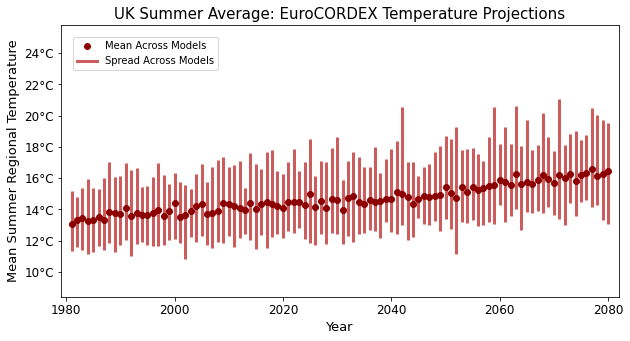

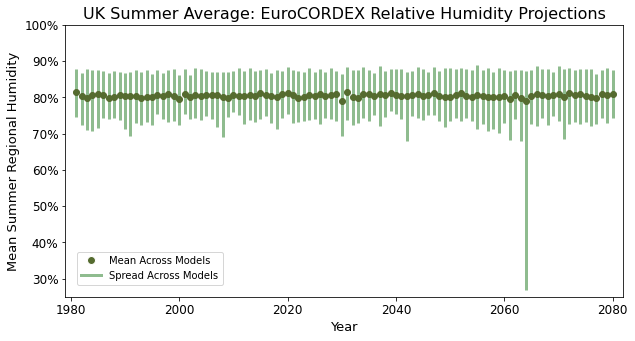

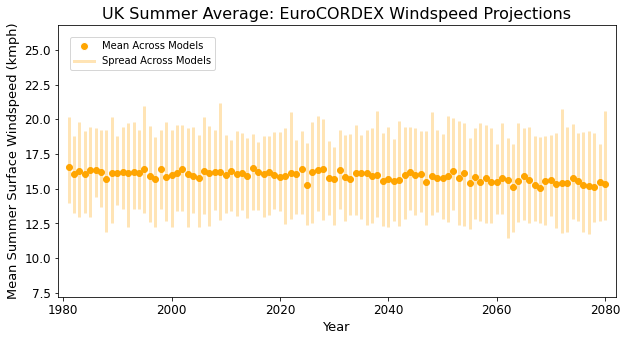

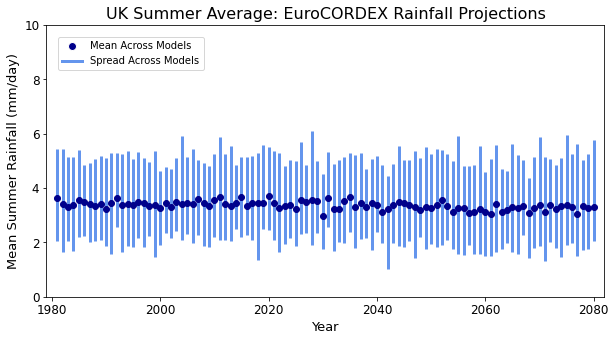

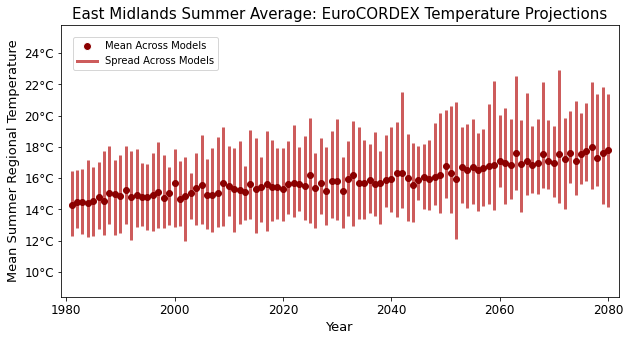

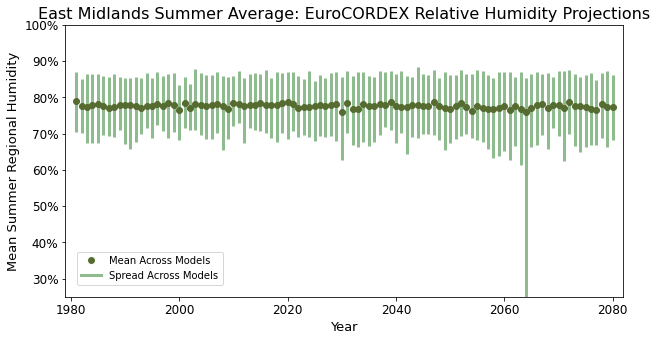

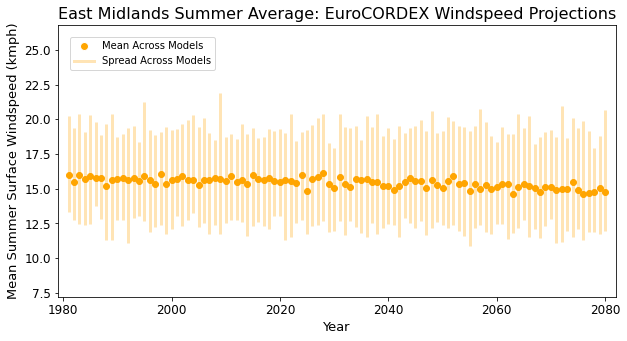

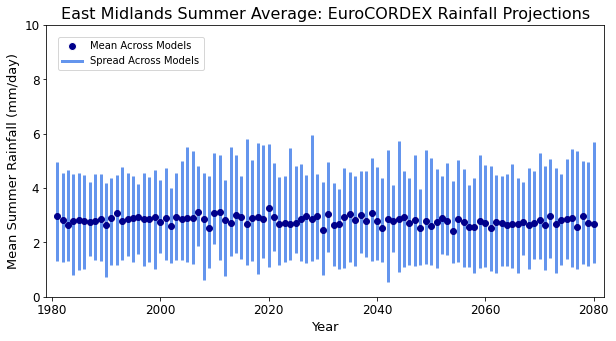

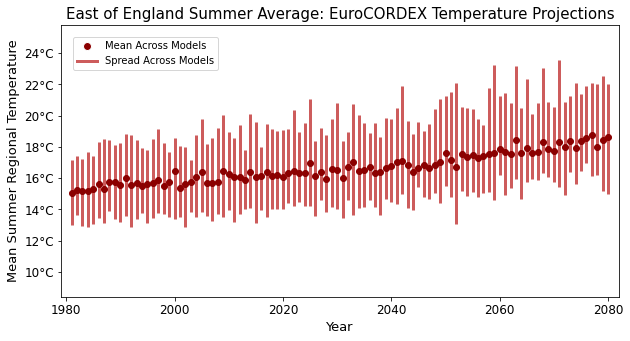

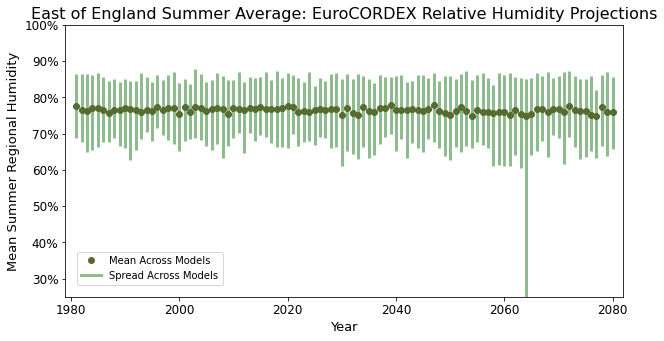

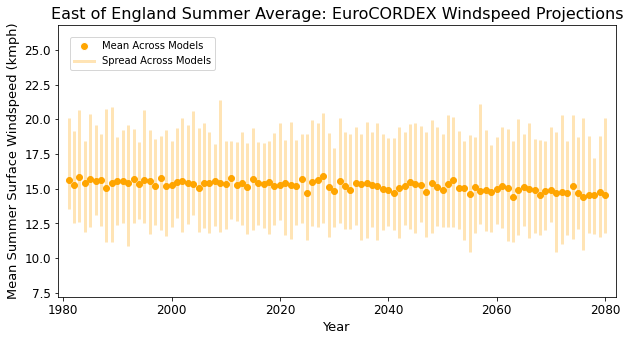

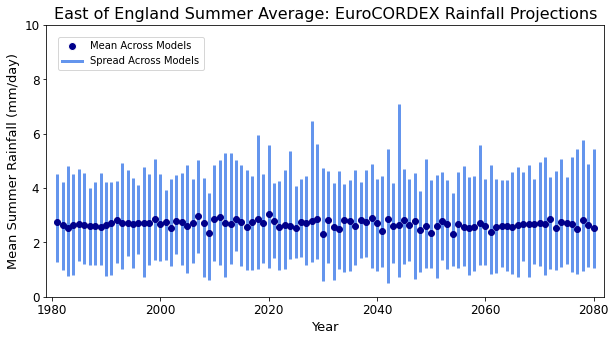

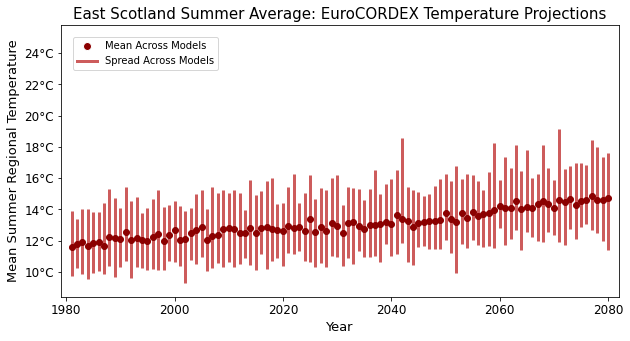

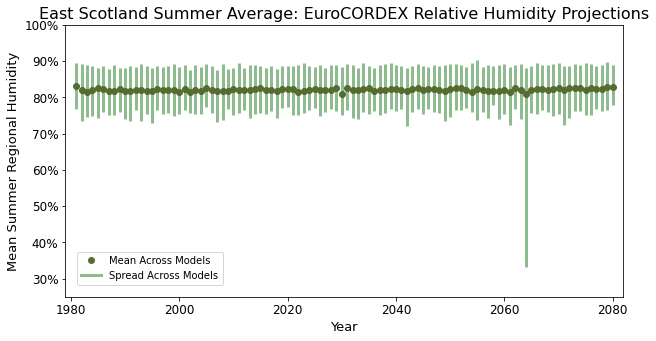

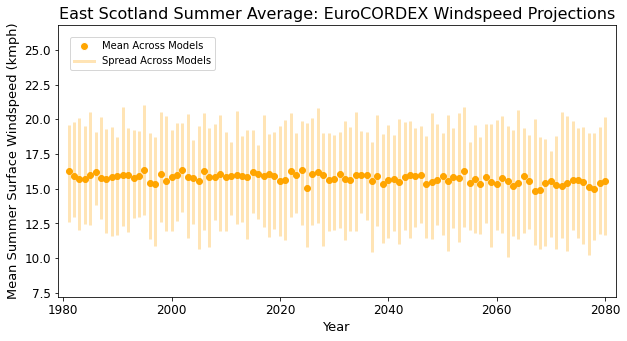

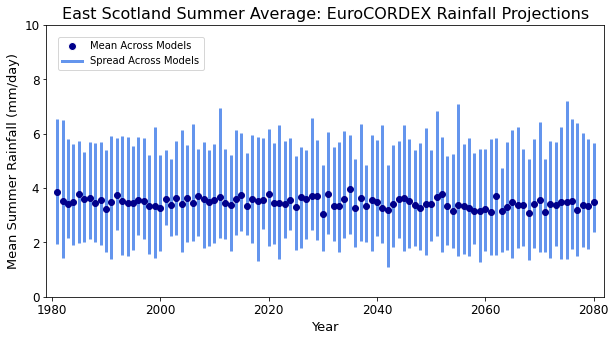

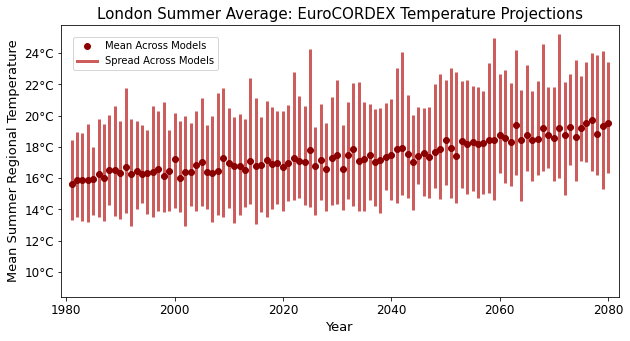

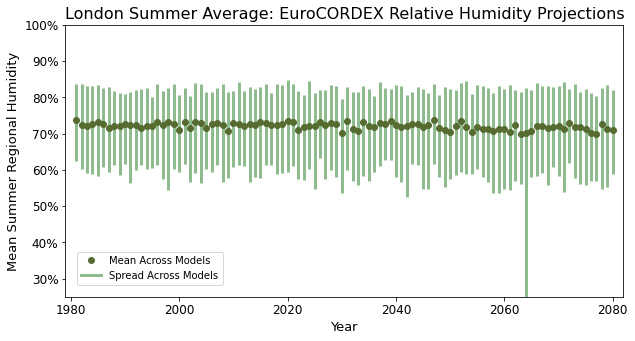

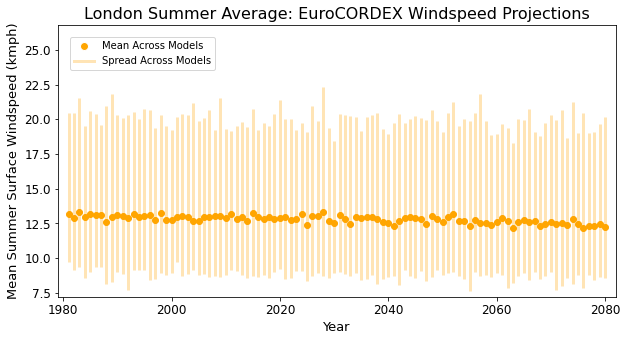

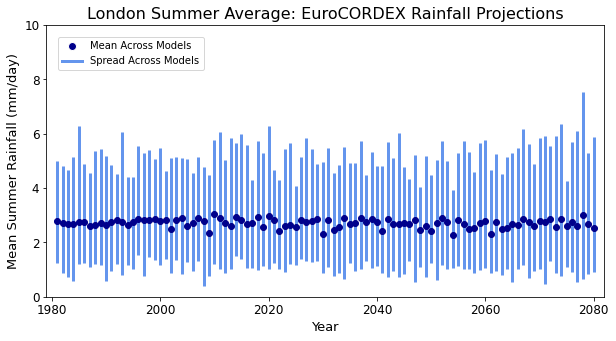

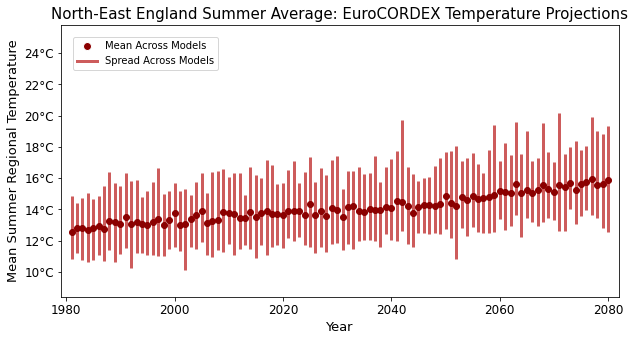

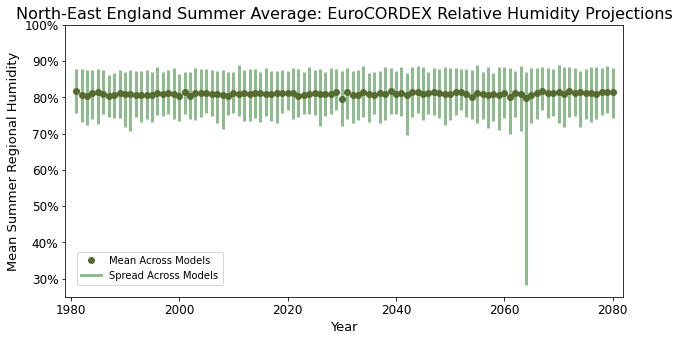

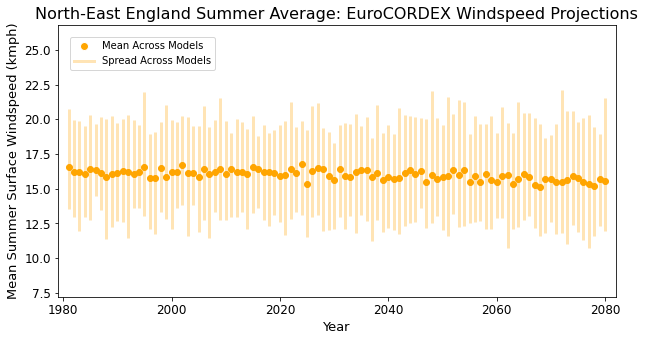

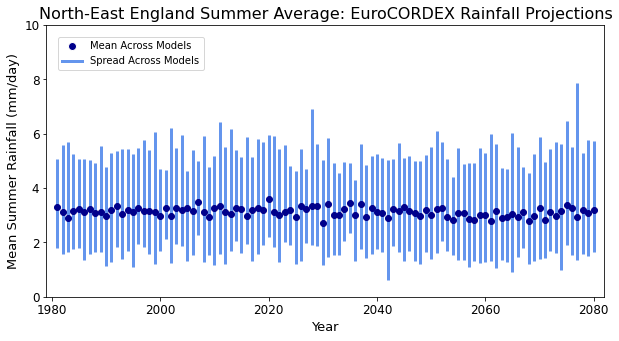

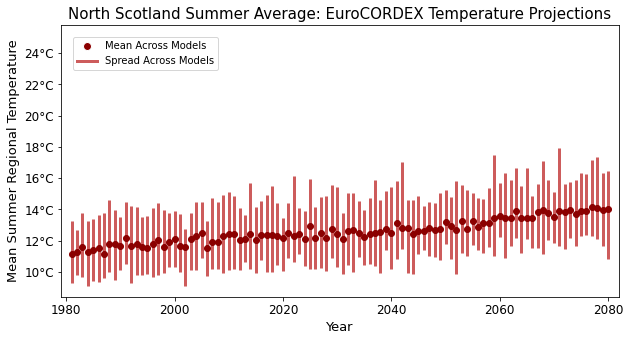

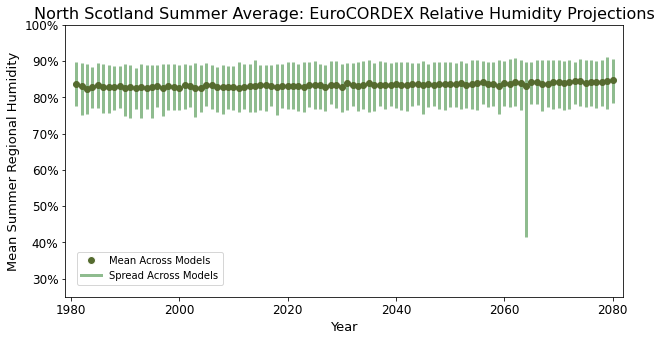

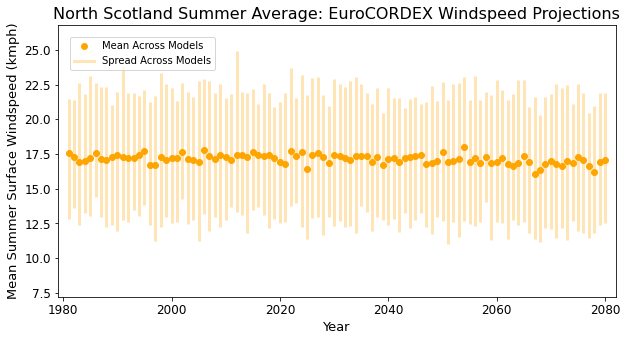

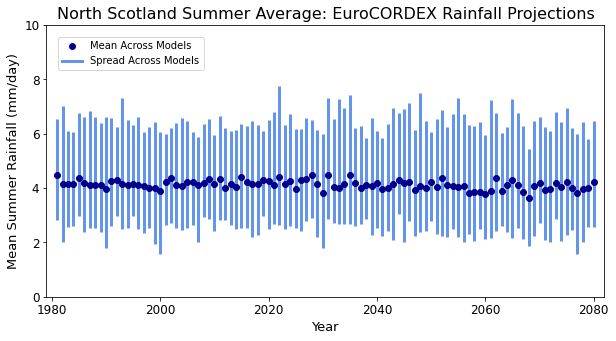

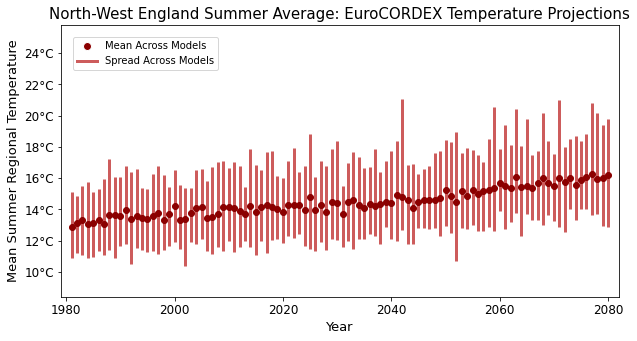

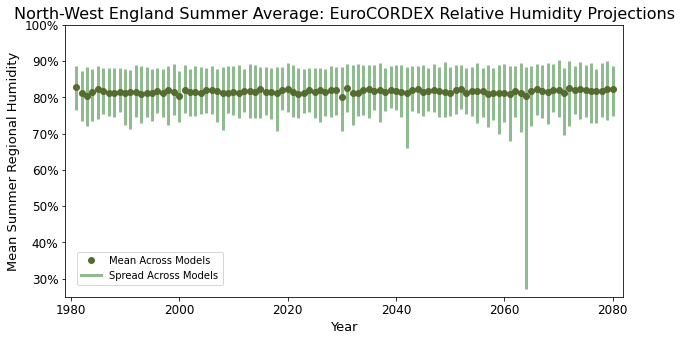

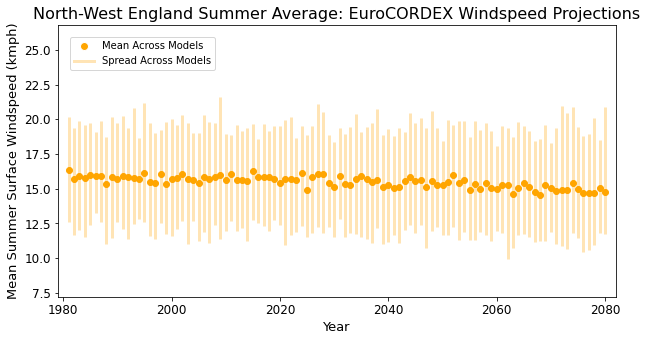

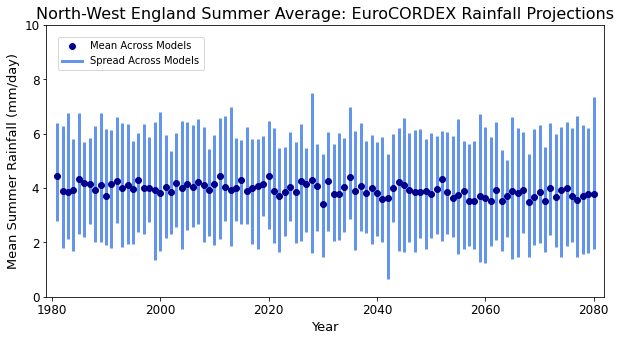

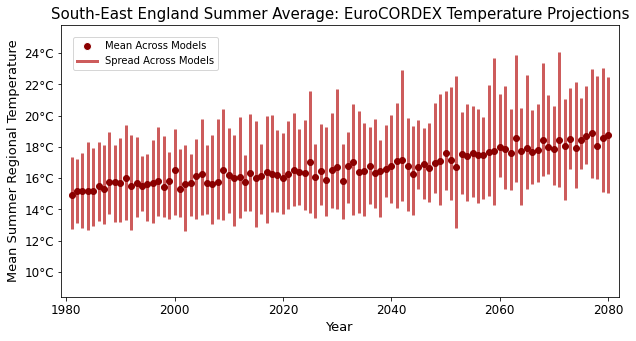

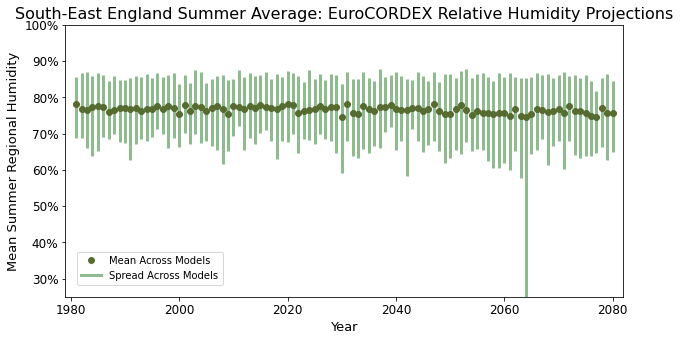

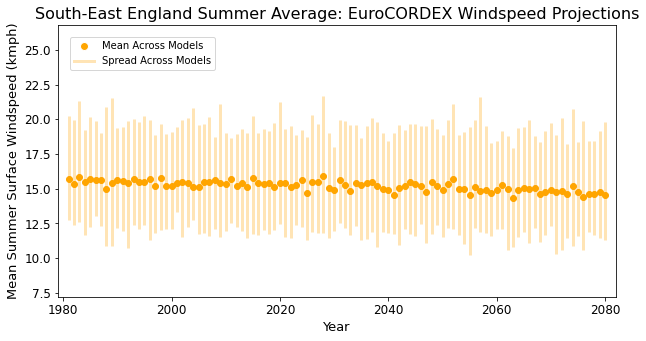

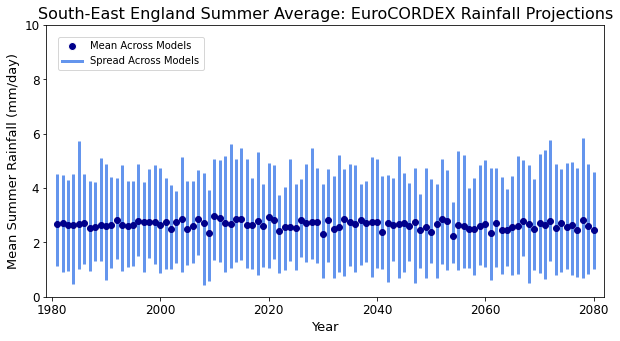

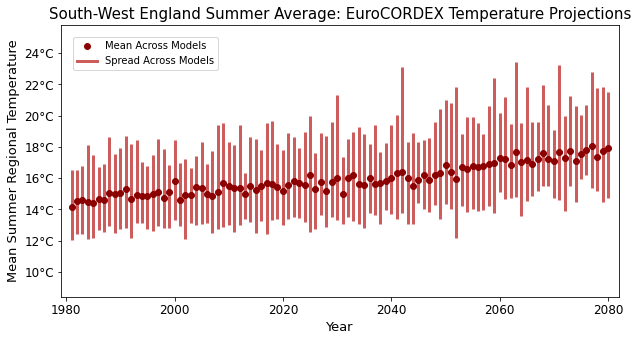

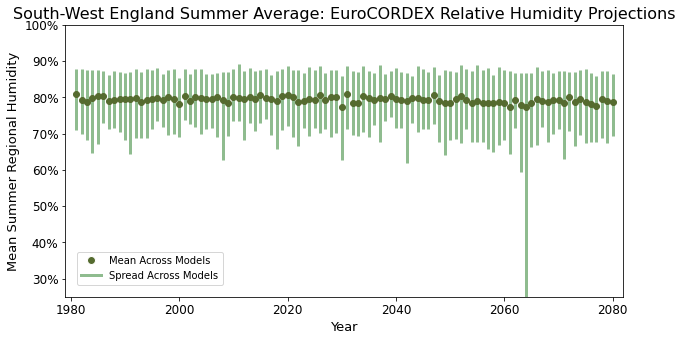

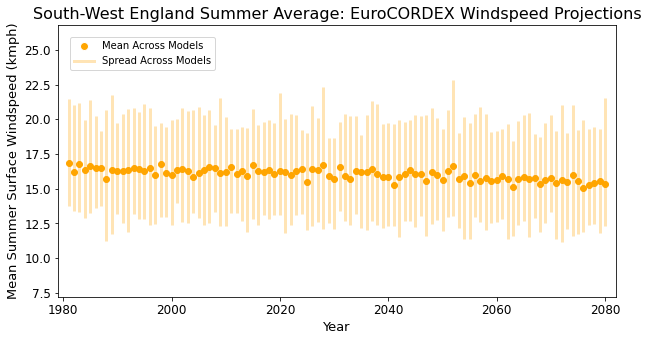

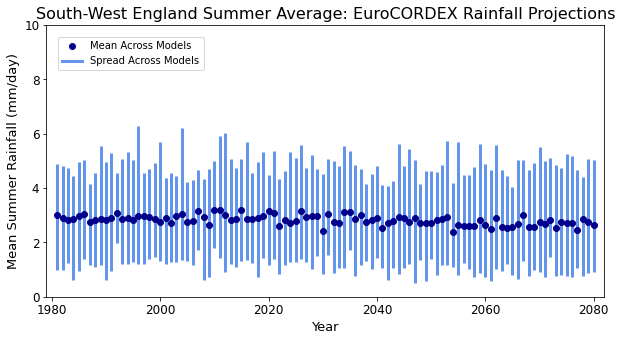

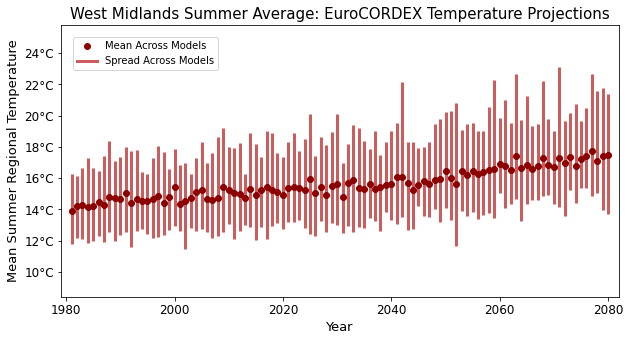

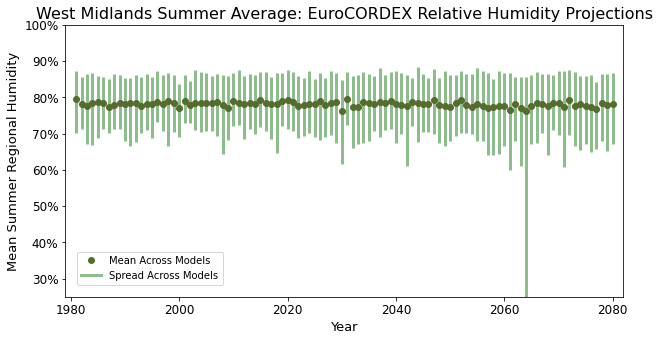

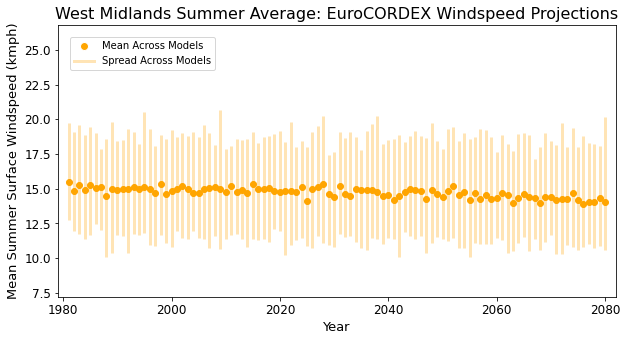

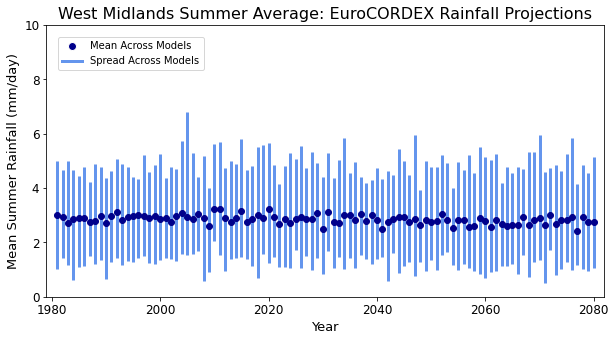

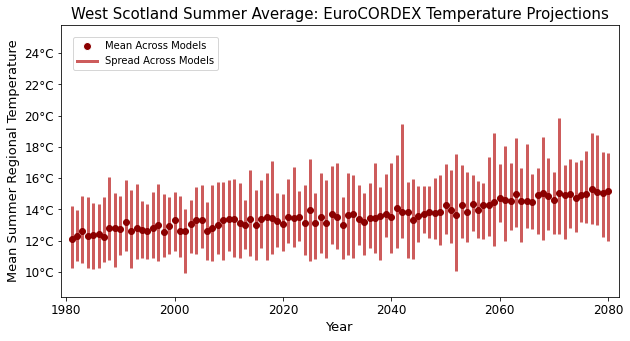

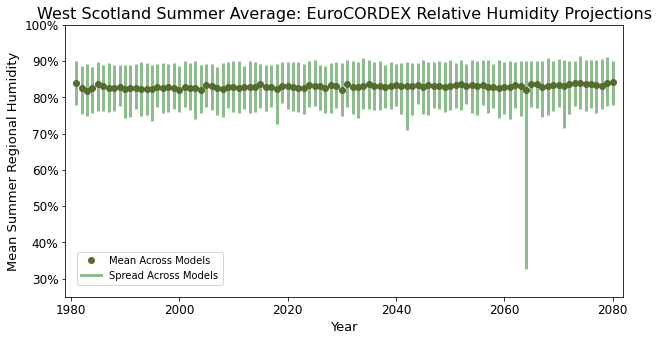

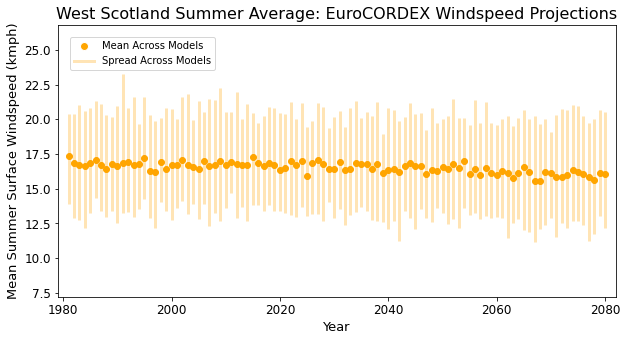

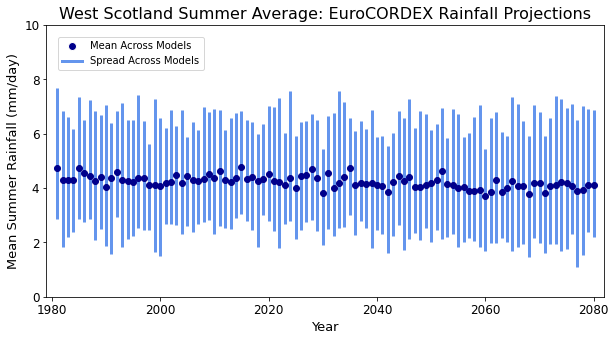

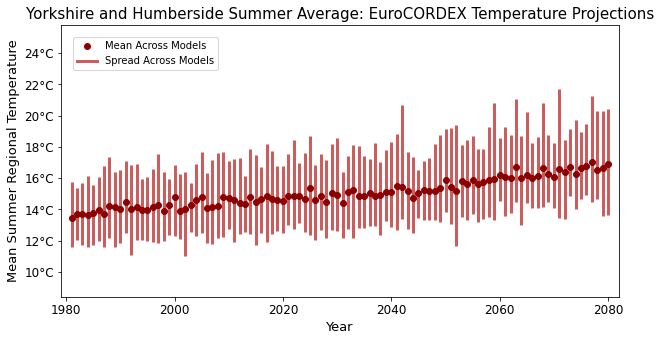

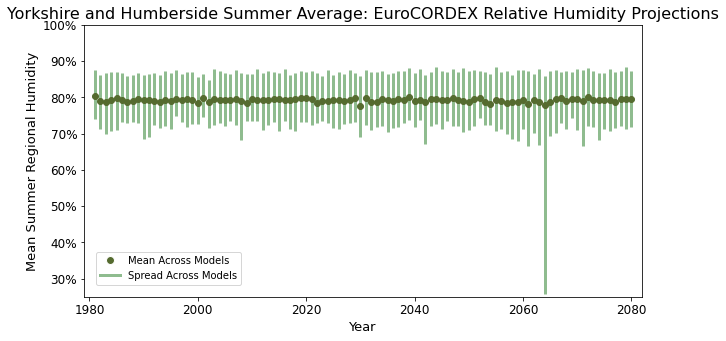

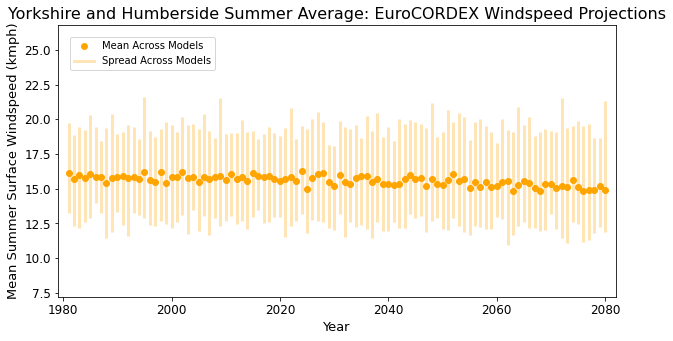

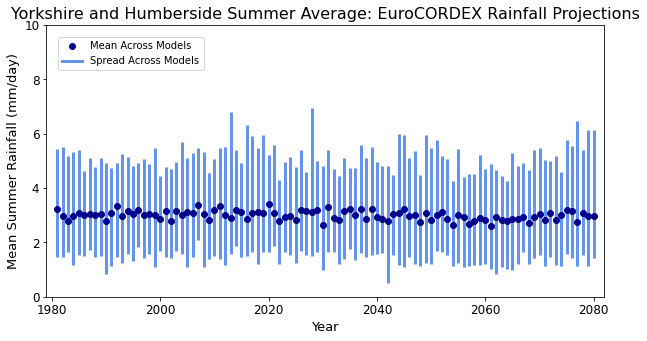

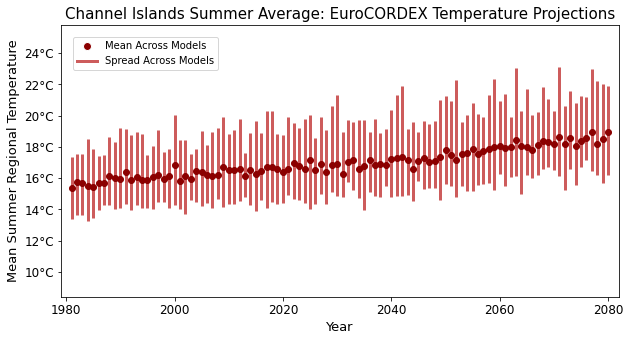

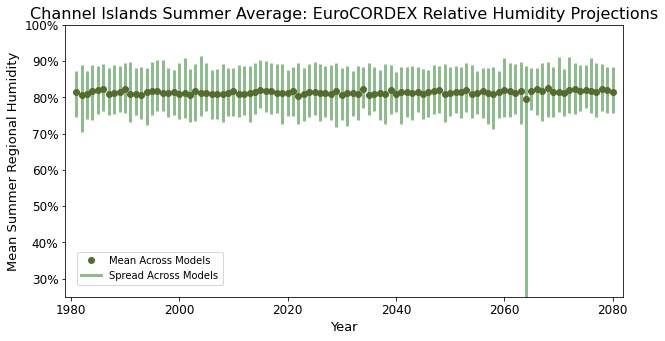

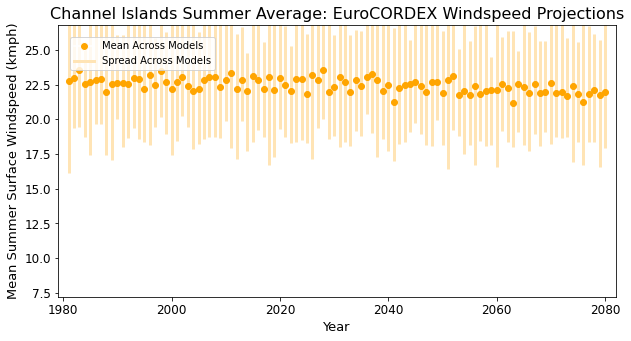

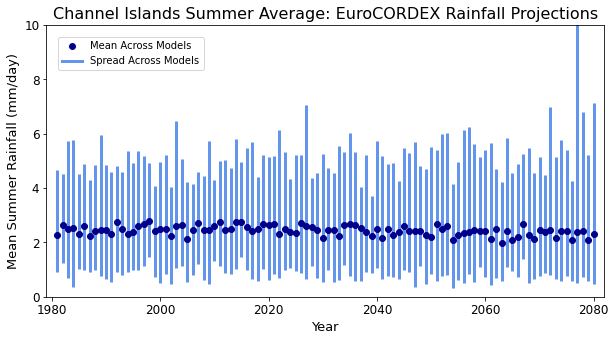

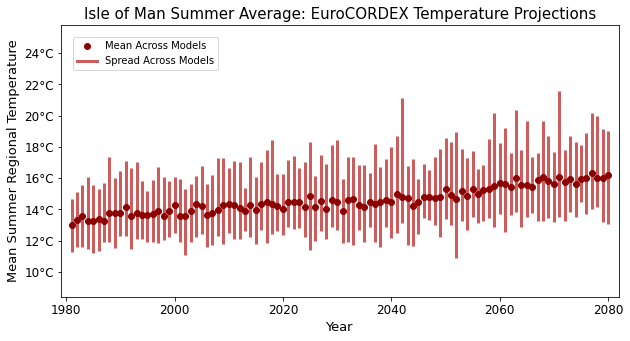

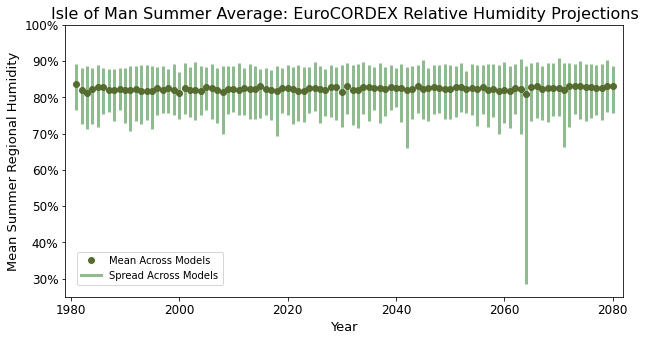

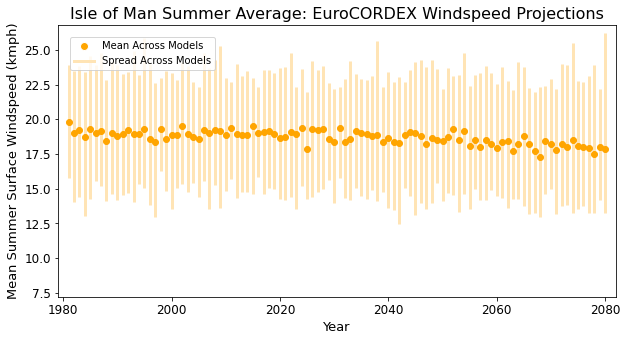

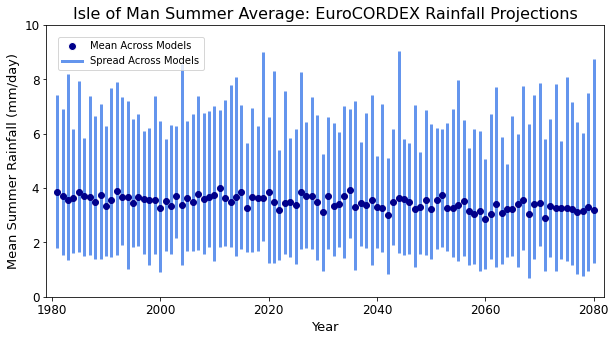

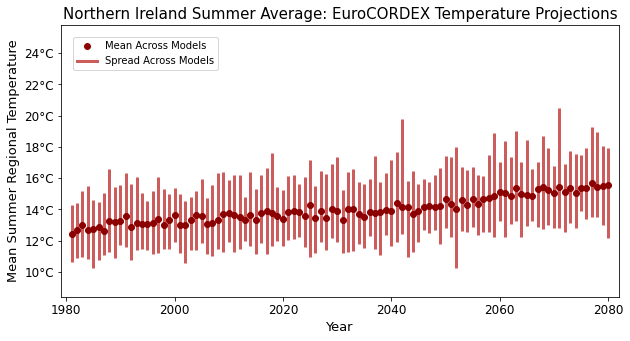

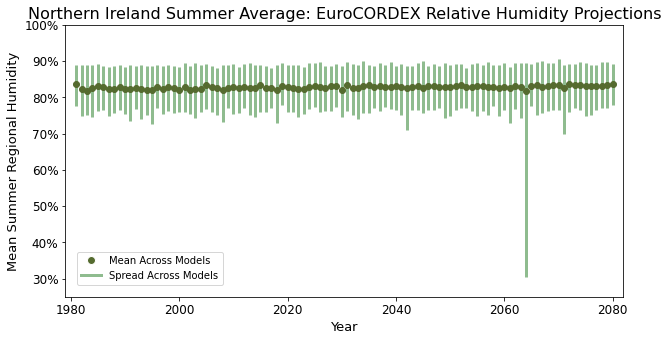

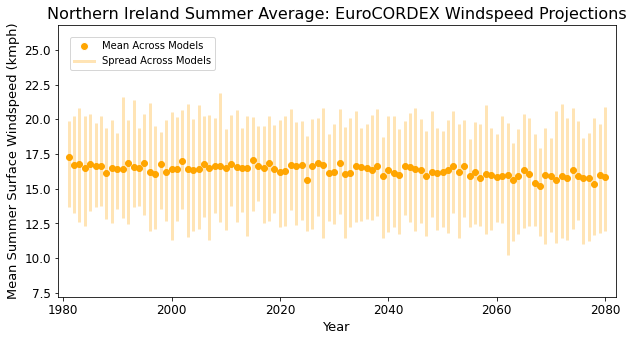

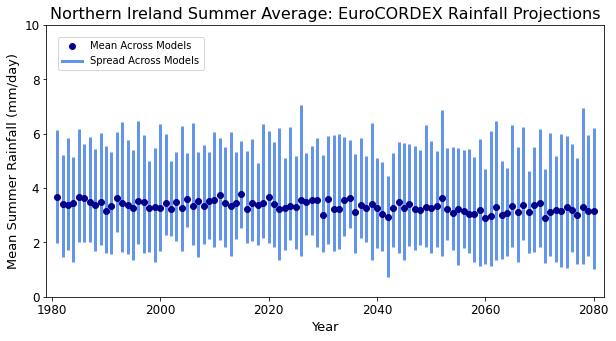

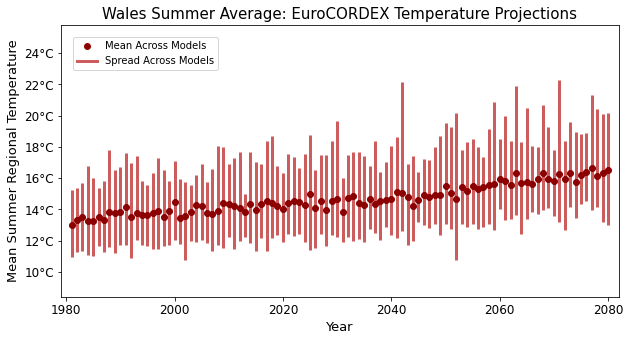

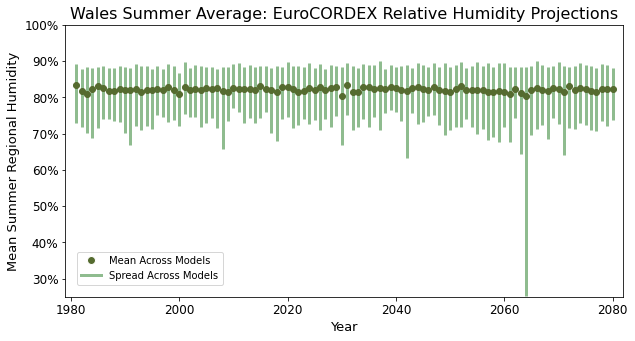

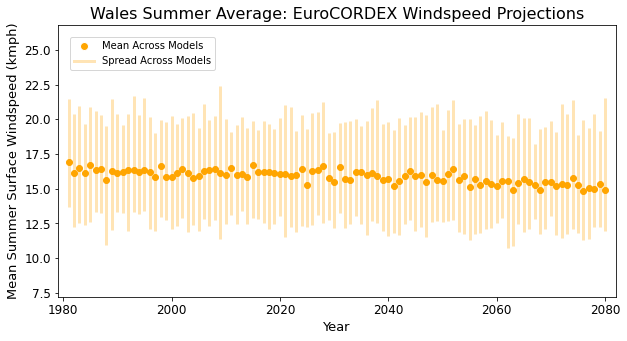

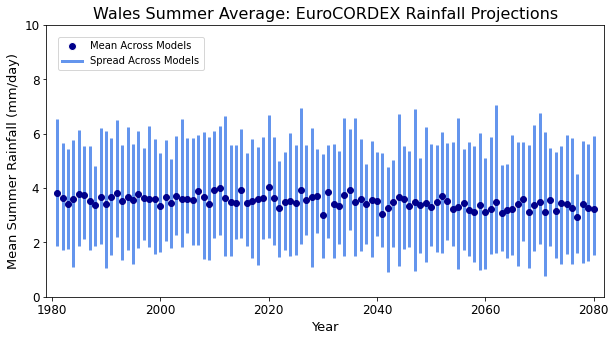

In [55]:
# Making plot:
ids = ['UK', 'East Midlands', 'East of England',
       'East Scotland','London','North-East England',
       'North Scotland','North-West England',
       'South-East England','South-West England',
       'West Midlands','West Scotland',
       'Yorkshire and Humberside',
       'Channel Islands',
       'Isle of Man',
       'Northern Ireland','Wales']
save_ids = ['uk', 'e_mdls', 'e_eng',
       'e_scot','ldn','ne_eng',
       'n_scot','nw_eng',
       'se_eng','sw_eng',
       'w_mdls','w_scot',
       'yorks_n_hums',
       'chnl_isl',
       'isl_man',
       'n_irln','wales']
for j in range(17):
    # Loading data:
    tas_file_names = [f'/home/theo/outdata/01_data/tas_model_{i+1}_region_{j}_summer.npy' 
                  for i in range(48)]
    tas_data = np.array([np.load(fname) for fname in tas_file_names])
    hurs_file_names = [f'/home/theo/outdata/01_data/hurs_model_{i+1}_region_{j}_summer.npy' 
                  for i in range(48)]
    hurs_data = np.array([np.load(fname) for fname in hurs_file_names])
    wind_file_names = [f'/home/theo/outdata/01_data/wind_model_{i+1}_region_{j}_summer.npy' 
                  for i in range(48)]
    wind_data = np.array([np.load(fname) for fname in wind_file_names])
    pr_file_names = [f'/home/theo/outdata/01_data/pr_model_{i+1}_region_{j}_summer.npy' 
                  for i in range(48)]
    pr_data = np.array([np.load(fname) for fname in pr_file_names])
    # Making dates:
    dates = [1980 + i for i in range(101)]
    
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
    
        # Plotting Temperature:
        plt.figure(figsize=(10, 5))
        plt.errorbar(dates, np.nanmean(tas_data,axis = 0), 
                     yerr=np.stack((np.nanmean(tas_data,axis = 0) - np.nanmin(tas_data,axis = 0),
                                    np.nanmax(tas_data,axis = 0) - np.nanmean(tas_data,axis = 0))), 
                     fmt='o', color='darkred', ecolor='indianred', 
                     elinewidth=3, capsize=0)
        plt.title(f'{ids[j]} Summer Average: EuroCORDEX Temperature Projections',fontsize=15)
        handles = [mpl.lines.Line2D([0], [0], marker='o', color='w',markerfacecolor='darkred', markersize=8),
                   mpl.lines.Line2D([0], [0], color='indianred', linewidth=3, linestyle='-')]
        plt.legend(handles,['Mean Across Models','Spread Across Models'],loc=2,borderaxespad=1.2)
        plt.xlabel('Year',fontsize=13)
        plt.ylabel('Mean Summer Regional Temperature',fontsize=13)
        plt.xticks(fontsize = 12)
        plt.yticks(fontsize = 12)
        plt.margins(x=0.02)
        plt.ylim(8.4,25.8)
        plt.gca().yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter(u"{x:.0f}°C"))
        plt.savefig(f'/home/theo/images/01_cordex_inputs/summer_tas_mean_{save_ids[j]}')
        
        # Plotting Relative Humidity:
        plt.figure(figsize=(10, 5))
        plt.errorbar(dates, np.nanmean(hurs_data,axis = 0), 
                     yerr=np.stack((np.nanmean(hurs_data,axis = 0) - np.nanmin(hurs_data,axis = 0),
                                    np.nanmax(hurs_data,axis = 0) - np.nanmean(hurs_data,axis = 0))), 
                     fmt='o', color='darkolivegreen', ecolor='darkseagreen', 
                     elinewidth=3, capsize=0)
        plt.title(f'{ids[j]} Summer Average: EuroCORDEX Relative Humidity Projections',fontsize=16)
        handles = [mpl.lines.Line2D([0], [0], marker='o', color='w',markerfacecolor='darkolivegreen', markersize=8),
                   mpl.lines.Line2D([0], [0], color='darkseagreen', linewidth=3, linestyle='-')]
        plt.legend(handles,['Mean Across Models','Spread Across Models'],loc=3,borderaxespad=1.2)
        plt.xlabel('Year',fontsize=13)
        plt.ylabel('Mean Summer Regional Humidity',fontsize=13)
        plt.xticks(fontsize = 12)
        plt.yticks(fontsize = 12)
        plt.margins(x=0.02) 
        plt.ylim(25,100)
        plt.gca().yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter(u"{x:.0f}%"))
        plt.savefig(f'/home/theo/images/01_cordex_inputs/summer_hurs_mean_{save_ids[j]}')
        
        # Plotting Wind:
        plt.figure(figsize=(10, 5))
        plt.errorbar(dates, np.nanmean(wind_data,axis = 0), 
                     yerr=np.stack((np.nanmean(wind_data,axis = 0) - np.nanmin(wind_data,axis = 0),
                                    np.nanmax(wind_data,axis = 0) - np.nanmean(wind_data,axis = 0))), 
                     fmt='o', color='orange', ecolor='moccasin', 
                     elinewidth=3, capsize=0)
        plt.title(f'{ids[j]} Summer Average: EuroCORDEX Windspeed Projections',fontsize=16)
        handles = [mpl.lines.Line2D([0], [0], marker='o', color='w',markerfacecolor='orange', markersize=8),
                   mpl.lines.Line2D([0], [0], color='moccasin', linewidth=3, linestyle='-')]
        plt.legend(handles,['Mean Across Models','Spread Across Models'],loc=2,borderaxespad=1.2)
        plt.xlabel('Year',fontsize=13)
        plt.ylabel('Mean Summer Surface Windspeed (kmph)',fontsize=13)
        plt.xticks(fontsize = 12)
        plt.yticks(fontsize = 12)
        plt.margins(x=0.02)      
        plt.ylim(7.2,26.8)
        plt.savefig(f'/home/theo/images/01_cordex_inputs/summer_wind_mean_{save_ids[j]}')
        
        # Plotting Rainfall:
        plt.figure(figsize=(10, 5))
        plt.errorbar(dates, np.nanmean(pr_data,axis = 0), 
                     yerr=np.stack((np.nanmean(pr_data,axis = 0) - np.nanmin(pr_data,axis = 0),
                                    np.nanmax(pr_data,axis = 0) - np.nanmean(pr_data,axis = 0))), 
                     fmt='o', color='darkblue', ecolor='cornflowerblue', 
                     elinewidth=3, capsize=0)
        plt.title(f'{ids[j]} Summer Average: EuroCORDEX Rainfall Projections',fontsize=16)
        handles = [mpl.lines.Line2D([0], [0], marker='o', color='w',markerfacecolor='darkblue', markersize=8),
                   mpl.lines.Line2D([0], [0], color='cornflowerblue', linewidth=3, linestyle='-')]
        plt.legend(handles,['Mean Across Models','Spread Across Models'],loc=2,borderaxespad=1.2)
        plt.xlabel('Year',fontsize=13)
        plt.ylabel('Mean Summer Rainfall (mm/day)',fontsize=13)
        plt.xticks(fontsize = 12)
        plt.yticks(fontsize = 12)
        plt.margins(x=0.02)      
        plt.ylim(0,10)
        plt.savefig(f'/home/theo/images/01_cordex_inputs/summer_pr_mean_{save_ids[j]}')

In [82]:
# For purposes of building summary:
# Gradients of mean
# Mean range in each quarter
# mean
# max 
# min for each plot.

print('Temperature:')
data = {'UK': [0,0,0,0,0],
        'East Midlands': [0,0,0,0,0],
        'East of England': [0,0,0,0,0],
       'East Scotland': [0,0,0,0,0],
        'London': [0,0,0,0,0],
        'North-East England': [0,0,0,0,0],
       'North Scotland': [0,0,0,0,0],
        'North-West England': [0,0,0,0,0],
       'South-East England': [0,0,0,0,0],
        'South-West England': [0,0,0,0,0],
       'West Midlands': [0,0,0,0,0],
        'West Scotland': [0,0,0,0,0],
       'Yorkshire and Humberside': [0,0,0,0,0],
       'Channel Islands': [0,0,0,0,0],
       'Isle of Man': [0,0,0,0,0],
       'Northern Ireland': [0,0,0,0,0],
        'Wales': [0,0,0,0,0]
       }
    
df = pd.DataFrame (data, columns = ['UK', 'East Midlands', 'East of England',
       'East Scotland','London','North-East England',
       'North Scotland','North-West England',
       'South-East England','South-West England',
       'West Midlands','West Scotland',
       'Yorkshire and Humberside',
       'Channel Islands',
       'Isle of Man',
       'Northern Ireland','Wales'])

df.index = ['Gradient', 'Range', 'Mean', 'Max', 'Min']

Temperature:


In [92]:
# Temperature:
df_tas = df.copy()

grad = []
rang = []
mins = []
maxs = []
means= []

for j in range(17):
    # Loading data:
    tas_file_names = [f'/home/theo/outdata/01_data/tas_model_{i+1}_region_{j}_summer.npy' 
                  for i in range(48)]
    tas_data = np.array([np.load(fname) for fname in tas_file_names])
    
    grad.append(np.polyfit(np.arange(100),np.nanmean(tas_data,axis = 0)[1:],1)[0])
    rang.append(np.max(tas_data[:,1:]) - np.min(tas_data[:,1:]))
    means.append(np.mean(tas_data[:,1:]))
    mins.append(np.min(tas_data[:,1:]))
    maxs.append(np.max(tas_data[:,1:]))
    
df_tas.loc['Gradient':'Gradient','UK':'Wales']=grad
df_tas.loc['Range':'Range','UK':'Wales']=rang
df_tas.loc['Mean':'Mean','UK':'Wales']=means
df_tas.loc['Max':'Max','UK':'Wales']=maxs
df_tas.loc['Min':'Min','UK':'Wales']=mins

df_tas.to_csv('/home/theo/images/01_cordex_inputs/mean_values/tas_mean.csv')

(48, 101)


<ipython-input-92-c646c6bffbf3>:16: RuntimeWarning: Mean of empty slice
  grad.append(np.polyfit(np.arange(100),np.nanmean(tas_data,axis = 0)[1:],1)[0])


In [97]:
# RH:
df_hurs = df.copy()

grad = []
rang = []
mins = []
maxs = []
means= []

for j in range(17):
    # Loading data:
    hurs_file_names = [f'/home/theo/outdata/01_data/hurs_model_{i+1}_region_{j}_summer.npy' 
                  for i in range(48)]
    hurs_data = np.array([np.load(fname) for fname in hurs_file_names])
    
    grad.append(np.polyfit(np.arange(100),np.nanmean(hurs_data,axis = 0)[1:],1)[0])
    rang.append(np.max(hurs_data[:,1:]) - np.min(hurs_data[:,1:]))
    means.append(np.mean(hurs_data[:,1:]))
    mins.append(np.min(hurs_data[:,1:]))
    maxs.append(np.max(hurs_data[:,1:]))
    
df_hurs.loc['Gradient':'Gradient','UK':'Wales']=grad
df_hurs.loc['Range':'Range','UK':'Wales']=rang
df_hurs.loc['Mean':'Mean','UK':'Wales']=means
df_hurs.loc['Max':'Max','UK':'Wales']=maxs
df_hurs.loc['Min':'Min','UK':'Wales']=mins

df_hurs.to_csv('/home/theo/images/01_cordex_inputs/mean_values/hurs_mean.csv')
df_hurs

<ipython-input-97-abc783c02388>:16: RuntimeWarning: Mean of empty slice
  grad.append(np.polyfit(np.arange(100),np.nanmean(hurs_data,axis = 0)[1:],1)[0])


,UK,East Midlands,East of England,East Scotland,London,North-East England,North Scotland,North-West England,South-East England,South-West England,West Midlands,West Scotland,Yorkshire and Humberside,Channel Islands,Isle of Man,Northern Ireland,Wales
Gradient,0.000082,-0.005978,-0.007776,0.003136,-0.014110,0.002532,0.015280,0.003969,-0.014485,-0.011211,-0.006931,0.009381,-0.000952,0.004025,0.005368,0.007173,-0.001922
Range,61.969244,64.089036,64.758568,57.169833,62.719621,60.623301,49.506043,63.274451,65.744244,66.194927,63.842582,58.661007,62.762438,70.810929,62.306529,60.139935,64.739183
Mean,80.497260,77.678360,76.491288,82.125048,72.095668,81.048574,83.458983,81.642635,76.649703,79.372461,78.170254,83.031373,79.234467,81.417560,82.410942,82.840231,82.166809
Max,88.878975,88.308272,87.787135,90.275663,84.764330,88.991858,91.042664,90.411373,87.854827,89.117465,88.295006,91.322052,88.398027,91.541398,90.906864,90.483536,90.061937
Min,26.909731,24.219237,23.028567,33.105830,22.044709,28.368557,41.536621,27.136922,22.110583,22.922538,24.452425,32.661045,25.635588,20.730469,28.600335,30.343601,25.322754


In [98]:
# wind:
df_wind = df.copy()

grad = []
rang = []
mins = []
maxs = []
means= []

for j in range(17):
    # Loading data:
    wind_file_names = [f'/home/theo/outdata/01_data/wind_model_{i+1}_region_{j}_summer.npy' 
                  for i in range(48)]
    wind_data = np.array([np.load(fname) for fname in wind_file_names])
    
    grad.append(np.polyfit(np.arange(100),np.nanmean(wind_data,axis = 0)[1:],1)[0])
    rang.append(np.max(wind_data[:,1:]) - np.min(wind_data[:,1:]))
    means.append(np.mean(wind_data[:,1:]))
    mins.append(np.min(wind_data[:,1:]))
    maxs.append(np.max(wind_data[:,1:]))
    
df_wind.loc['Gradient':'Gradient','UK':'Wales']=grad
df_wind.loc['Range':'Range','UK':'Wales']=rang
df_wind.loc['Mean':'Mean','UK':'Wales']=means
df_wind.loc['Max':'Max','UK':'Wales']=maxs
df_wind.loc['Min':'Min','UK':'Wales']=mins

df_wind.to_csv('/home/theo/images/01_cordex_inputs/mean_values/wind_mean.csv')
df_wind

<ipython-input-98-9fa92e5567e4>:16: RuntimeWarning: Mean of empty slice
  grad.append(np.polyfit(np.arange(100),np.nanmean(wind_data,axis = 0)[1:],1)[0])


,UK,East Midlands,East of England,East Scotland,London,North-East England,North Scotland,North-West England,South-East England,South-West England,West Midlands,West Scotland,Yorkshire and Humberside,Channel Islands,Isle of Man,Northern Ireland,Wales
Gradient,-0.008455,-0.008703,-0.008763,-0.006032,-0.006465,-0.007429,-0.004743,-0.010376,-0.008899,-0.010166,-0.008977,-0.009102,-0.008185,-0.009182,-0.011688,-0.009207,-0.012218
Range,9.724403,11.007477,10.951182,11.027716,14.681379,11.399274,13.969705,11.674792,11.454868,11.668213,10.597032,12.061834,10.656702,17.963570,13.764089,11.688004,11.682916
Mean,15.890646,15.425550,15.199415,15.739117,12.784920,15.992830,17.140169,15.491036,15.200523,16.036080,14.714601,16.511615,15.584930,22.454495,18.695502,16.313985,15.873763
Max,21.154478,21.862652,21.357899,21.062527,22.335180,22.113523,24.944806,21.620338,21.645413,22.823960,20.659621,23.245601,21.579529,34.058542,26.242822,21.883016,22.367272
Min,11.430075,10.855176,10.406717,10.034812,7.653801,10.714249,10.975100,9.945546,10.190545,11.155747,10.062590,11.183767,10.922827,16.094971,12.478733,10.195012,10.684355


In [99]:
# rain:
df_pr = df.copy()

grad = []
rang = []
mins = []
maxs = []
means= []

for j in range(17):
    # Loading data:
    pr_file_names = [f'/home/theo/outdata/01_data/pr_model_{i+1}_region_{j}_summer.npy' 
                  for i in range(48)]
    pr_data = np.array([np.load(fname) for fname in pr_file_names])
    
    grad.append(np.polyfit(np.arange(100),np.nanmean(pr_data,axis = 0)[1:],1)[0])
    rang.append(np.max(pr_data[:,1:]) - np.min(pr_data[:,1:]))
    means.append(np.mean(pr_data[:,1:]))
    mins.append(np.min(pr_data[:,1:]))
    maxs.append(np.max(pr_data[:,1:]))
    
df_pr.loc['Gradient':'Gradient','UK':'Wales']=grad
df_pr.loc['Range':'Range','UK':'Wales']=rang
df_pr.loc['Mean':'Mean','UK':'Wales']=means
df_pr.loc['Max':'Max','UK':'Wales']=maxs
df_pr.loc['Min':'Min','UK':'Wales']=mins

df_pr.to_csv('/home/theo/images/01_cordex_inputs/mean_values/pr_mean.csv')
df_pr

<ipython-input-99-b5c3c2e63e4d>:16: RuntimeWarning: Mean of empty slice
  grad.append(np.polyfit(np.arange(100),np.nanmean(pr_data,axis = 0)[1:],1)[0])


,UK,East Midlands,East of England,East Scotland,London,North-East England,North Scotland,North-West England,South-East England,South-West England,West Midlands,West Scotland,Yorkshire and Humberside,Channel Islands,Isle of Man,Northern Ireland,Wales
Gradient,-0.002458,-0.001643,-0.000815,-0.002317,-0.000925,-0.001542,-0.002017,-0.004233,-0.001138,-0.003075,-0.002120,-0.004196,-0.001836,-0.002283,-0.005212,-0.003699,-0.004402
Range,5.060849,5.426799,6.568118,6.123369,7.137543,7.254049,6.199326,6.840741,5.407241,5.798021,6.278034,6.584572,6.421385,9.706393,8.327757,6.305994,6.282150
Mean,3.366978,2.804008,2.675930,3.463564,2.708605,3.124137,4.125016,3.942851,2.654416,2.825849,2.851370,4.231158,2.999997,2.438060,3.467653,3.332954,3.501188
Max,6.082516,5.959926,7.079661,7.203740,7.551220,7.862497,7.773558,7.502112,5.846750,6.291485,6.795722,7.689358,6.947094,10.033414,9.037595,7.046004,7.054227
Min,1.021667,0.533127,0.511543,1.080371,0.413678,0.608449,1.574232,0.661371,0.439509,0.493464,0.517688,1.104786,0.525708,0.327022,0.709838,0.740010,0.772077


##### Part B: Maps

In [4]:
# Load data:

# Rough plot of 1980-2000 (so no multidecadal trends skewing results)

# Rough plot of 2060-2080 (so no multidecadal trends skewing results)

In [5]:
# Getting data location
directories,tas_files,hurs_files,wind_files,pr_files = get_cordex_addresses()

<class 'list'>


In [6]:
i = 0
tas_data  = xarray.open_dataset(directories[i] + tas_files[i], engine = "netcdf4")
years = np.array(pd.to_datetime(np.array(tas_data.time)).year)
months = np.array(pd.to_datetime(np.array(tas_data.time)).month)
#1981-2000 summer indices: (First 20 years of run)
year_inds = np.where(years <= 2000)
summer_inds=np.concatenate((np.where(months == 6)[0],
                            np.where(months == 7)[0],
                            np.where(months == 8)[0]),
                            axis = 0)
indices_80to00 = np.intersect1d(year_inds,summer_inds)
#2061-2080 summer indices: (Last 20 years of run)
year_inds = np.where(years >= 2061)
summer_inds=np.concatenate((np.where(months == 6)[0],
                            np.where(months == 7)[0],
                            np.where(months == 8)[0]),
                            axis = 0)
indices_60to80 = np.intersect1d(year_inds,summer_inds)

In [58]:
i = 0
print(f'Stage {i}')
tas_data  = xarray.open_dataset(directories[i] + tas_files[i], engine = "netcdf4")
tas_80to00 = np.array(tas_data.tas[indices_80to00,:,:]) - 273.15
tas_60to80 = np.array(tas_data.tas[indices_60to80,:,:]) - 273.15
print(tas_80to00.shape)

Stage 0
(1840, 128, 108)


In [7]:
# Getting data for periods: 1980-2000 and 2060-1980
i = 0
print(f'Stage {i}')
tas_data  = xarray.open_dataset(directories[i] + tas_files[i], engine = "netcdf4")
tas_80to00 = np.array(tas_data.tas[indices_80to00,:,:]) - 273.15
tas_60to80 = np.array(tas_data.tas[indices_60to80,:,:]) - 273.15

hurs_data  = xarray.open_dataset(directories[i] + hurs_files[i], engine = "netcdf4")
hurs_80to00 = np.array(hurs_data.hurs[indices_80to00,:,:])
hurs_60to80 = np.array(hurs_data.hurs[indices_60to80,:,:])

wind_data  = xarray.open_dataset(directories[i] + wind_files[i], engine = "netcdf4")
wind_80to00 = np.array(wind_data.sfcWind[indices_80to00,:,:])*3.6
wind_60to80 = np.array(wind_data.sfcWind[indices_60to80,:,:])*3.6

pr_data  = xarray.open_dataset(directories[i] + pr_files[i], engine = "netcdf4")
pr_80to00 = np.array(pr_data.pr[indices_80to00,:,:])*86400
pr_60to80 = np.array(pr_data.pr[indices_60to80,:,:])*86400

for i in range(1,len(directories)):
    print(f'Stage {i}')
    
    temp1 = np.array(tas_data.tas[indices_80to00,:,:]) - 273.15
    tas_80to00 = np.concatenate((tas_80to00,temp1),axis=0)
    temp2 = np.array(tas_data.tas[indices_60to80,:,:]) - 273.15
    tas_60to80 = np.concatenate((tas_60to80,temp2),axis=0)
    
    hurs1 = np.array(hurs_data.hurs[indices_80to00,:,:])
    hurs_80to00 = np.concatenate((hurs_80to00,hurs1),axis=0)
    hurs2 = np.array(hurs_data.hurs[indices_60to80,:,:])
    hurs_60to80 = np.concatenate((hurs_60to80,hurs2),axis=0)
    
    wind1 = np.array(wind_data.sfcWind[indices_80to00,:,:])*3.6
    wind_80to00 = np.concatenate((wind_80to00,wind1),axis=0)
    wind2 = np.array(wind_data.sfcWind[indices_60to80,:,:])*3.6
    wind_60to80 = np.concatenate((wind_60to80,wind2),axis=0)
    
    pr1 = np.array(pr_data.pr[indices_80to00,:,:])*86400
    pr_80to00 = np.concatenate((pr_80to00,pr1),axis=0)
    pr2 = np.array(pr_data.pr[indices_60to80,:,:])*86400
    pr_60to80 = np.concatenate((pr_60to80,pr2),axis=0)

Stage 0
Stage 1
Stage 2
Stage 3
Stage 4
Stage 5
Stage 6
Stage 7
Stage 8
Stage 9
Stage 10
Stage 11
Stage 12
Stage 13
Stage 14
Stage 15
Stage 16
Stage 17
Stage 18
Stage 19
Stage 20
Stage 21
Stage 22
Stage 23
Stage 24
Stage 25
Stage 26
Stage 27
Stage 28
Stage 29
Stage 30
Stage 31
Stage 32
Stage 33
Stage 34
Stage 35
Stage 36
Stage 37
Stage 38
Stage 39
Stage 40
Stage 41
Stage 42
Stage 43
Stage 44
Stage 45
Stage 46
Stage 47
Stage 48


In [8]:
# Making mean over models data
tas_mean_80to00 = np.mean(tas_80to00,axis=0)
tas_mean_60to80 = np.mean(tas_60to80,axis=0)

hurs_mean_80to00 = np.mean(hurs_80to00,axis=0)
hurs_mean_60to80 = np.mean(hurs_60to80,axis=0)

wind_mean_80to00 = np.mean(wind_80to00,axis=0)
wind_mean_60to80 = np.mean(wind_60to80,axis=0)

pr_mean_80to00 = np.mean(pr_80to00,axis=0)
pr_mean_60to80 = np.mean(pr_60to80,axis=0)

In [9]:
# Making max over models data
tas_max_80to00 = np.max(tas_80to00,axis=0)
tas_max_60to80 = np.max(tas_60to80,axis=0)

hurs_max_80to00 = np.max(hurs_80to00,axis=0)
hurs_max_60to80 = np.max(hurs_60to80,axis=0)

wind_max_80to00 = np.max(wind_80to00,axis=0)
wind_max_60to80 = np.max(wind_60to80,axis=0)

pr_max_80to00 = np.max(pr_80to00,axis=0)
pr_max_60to80 = np.max(pr_60to80,axis=0)

In [10]:
# Making min over models data
tas_min_80to00 = np.min(tas_80to00,axis=0)
tas_min_60to80 = np.min(tas_60to80,axis=0)

hurs_min_80to00 = np.min(hurs_80to00,axis=0)
hurs_min_60to80 = np.min(hurs_60to80,axis=0)

wind_min_80to00 = np.min(wind_80to00,axis=0)
wind_min_60to80 = np.min(wind_60to80,axis=0)

pr_min_80to00 = np.min(pr_80to00,axis=0)
pr_min_60to80 = np.min(pr_60to80,axis=0)

In [14]:
del pr1,pr2,pr_60to80,pr_80to00
del temp1,temp2,tas_60to80,tas_80to00
del wind1,wind2,wind_60to80,wind_80to00
del hurs1,hurs2,hurs_60to80,hurs_80to00

In [16]:
region_data  = xarray.open_dataset('/home/theo/data/ukcp18-uk-land-region-rll.nc')
region_mask = region_data.admin_region
region_mask = np.nan_to_num(region_mask)
mask = np.logical_not(region_mask == 0)

In [18]:
import xarray
import numpy as np
import matplotlib as mpl
%matplotlib inline

# Add a couple of deep down individual functions.
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.ticker import AutoMinorLocator
import matplotlib.pyplot as plt
import cmasher as cmr
from matplotlib.ticker import MaxNLocator
from matplotlib.ticker import FormatStrFormatter

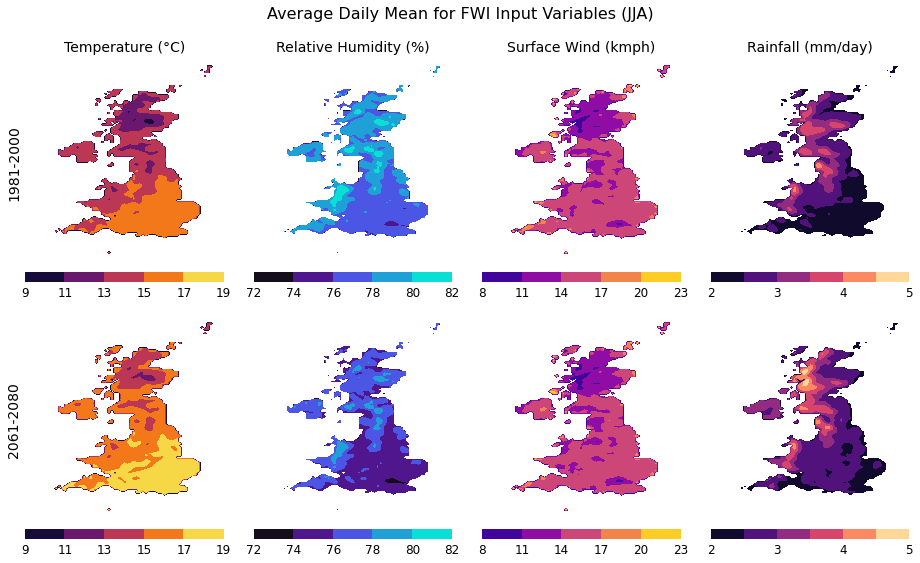

In [158]:
# Mean plots:
fig, axs = plt.subplots(2,4)
fig.set_figheight(8)
fig.set_figwidth(13)
fig.suptitle('Average Daily Mean for FWI Input Variables (JJA)', fontsize=16)


levels = np.linspace(9, 19, 5+1)
axs[0,0].set_title('Temperature (°C)',fontsize=14)
data00 = (tas_mean_80to00*mask)[5:115,20:85]
c00 = axs[0,0].contourf(data00,cmap=plt.get_cmap('inferno'),levels=levels)
axs[0,0].spines['top'].set_visible(False)
axs[0,0].spines['right'].set_visible(False)
axs[0,0].spines['bottom'].set_visible(False)
axs[0,0].spines['left'].set_visible(False)
axs[0,0].get_xaxis().set_ticks([])
axs[0,0].get_yaxis().set_ticks([])
axs[0,0].set_ylabel('1981-2000',fontsize=14)
divider = make_axes_locatable(axs[0,0])
cax = divider.append_axes('bottom', size='5%', pad=0.05)
cb00 = fig.colorbar(c00, cax=cax, orientation='horizontal')
cb00.outline.set_visible(False)
cb00.ax.tick_params(length=0,labelsize=12)
data01 = (tas_mean_60to80*mask)[5:115,20:85]
c01 = axs[1,0].contourf(data01,cmap=plt.get_cmap('inferno'),levels=levels)
axs[1,0].spines['top'].set_visible(False)
axs[1,0].spines['right'].set_visible(False)
axs[1,0].spines['bottom'].set_visible(False)
axs[1,0].spines['left'].set_visible(False)
axs[1,0].get_xaxis().set_ticks([])
axs[1,0].get_yaxis().set_ticks([])
axs[1,0].set_ylabel('2061-2080',fontsize=14)
divider = make_axes_locatable(axs[1,0])
cax = divider.append_axes('bottom', size='5%', pad=0.05)
cb01 = fig.colorbar(c01, cax=cax, orientation='horizontal')
cb01.outline.set_visible(False)
cb01.ax.tick_params(length=0,labelsize=12)


levels = np.linspace(72, 82, 5+1)
axs[0,1].set_title('Relative Humidity (%)',fontsize=14)
data10 = (hurs_mean_80to00*mask)[5:115,20:85]
c10 = axs[0,1].contourf(data10,cmap=plt.get_cmap('cmr.cosmic'),levels=levels)
axs[0,1].axis('off')
divider = make_axes_locatable(axs[0,1])
cax = divider.append_axes('bottom', size='5%', pad=0.05)
cb10 = fig.colorbar(c10, cax=cax, orientation='horizontal')
cb10.outline.set_visible(False)
cb10.ax.tick_params(length=0,labelsize=12)
data11 = (hurs_mean_60to80*mask)[5:115,20:85]
c11 = axs[1,1].contourf(data11,cmap=plt.get_cmap('cmr.cosmic'),levels=levels)
axs[1,1].axis('off')
divider = make_axes_locatable(axs[1,1])
cax = divider.append_axes('bottom', size='5%', pad=0.05)
cb11 = fig.colorbar(c11, cax=cax, orientation='horizontal')
cb11.outline.set_visible(False)
cb11.ax.tick_params(length=0,labelsize=12)


levels = np.linspace(8, 23, 5+1)
axs[0,2].set_title('Surface Wind (kmph)',fontsize=14)
data20 = (wind_mean_80to00*mask)[5:115,20:85]
c20 = axs[0,2].contourf(data20,cmap=plt.get_cmap('plasma'),levels=levels)
axs[0,2].axis('off')
divider = make_axes_locatable(axs[0,2])
cax = divider.append_axes('bottom', size='5%', pad=0.05)
cb20 = fig.colorbar(c20, cax=cax, orientation='horizontal')
cb20.outline.set_visible(False)
cb20.ax.tick_params(length=0,labelsize=12)
data21 = (wind_mean_60to80*mask)[5:115,20:85]
c21 = axs[1,2].contourf(data21,cmap=plt.get_cmap('plasma'),levels=levels)
axs[1,2].axis('off')
divider = make_axes_locatable(axs[1,2])
cax = divider.append_axes('bottom', size='5%', pad=0.05)
cb21 = fig.colorbar(c21, cax=cax, orientation='horizontal')
cb21.outline.set_visible(False)
cb21.ax.tick_params(length=0,labelsize=12)


levels = np.linspace(2, 5, 6+1)
axs[0,3].set_title('Rainfall (mm/day)',fontsize=14)
data30 = (pr_mean_80to00*mask)[5:115,20:85]
c30 = axs[0,3].contourf(data30,cmap=plt.get_cmap('magma'),levels=levels)
axs[0,3].axis('off')
divider = make_axes_locatable(axs[0,3])
cax = divider.append_axes('bottom', size='5%', pad=0.05)
cb30 = fig.colorbar(c30, cax=cax, orientation='horizontal')
cb30.outline.set_visible(False)
cb30.ax.tick_params(length=0,labelsize=12)
cb30.ax.xaxis.set_major_locator(MaxNLocator(integer=True))
cb30.ax.xaxis.set_major_formatter(FormatStrFormatter('%d'))
data31 = (pr_mean_60to80*mask)[5:115,20:85]
c31 = axs[1,3].contourf(data31,cmap=plt.get_cmap('magma'),levels=levels)
axs[1,3].axis('off')
divider = make_axes_locatable(axs[1,3])
cax = divider.append_axes('bottom', size='5%', pad=0.05)
cb31 = fig.colorbar(c31, cax=cax, orientation='horizontal')
cb31.outline.set_visible(False)
cb31.ax.tick_params(length=0,labelsize=12)
cb31.ax.xaxis.set_major_locator(MaxNLocator(integer=True))
cb31.ax.xaxis.set_major_formatter(FormatStrFormatter('%d'))

plt.tight_layout(pad=1.5)
plt.savefig('/home/theo/images/01_cordex_inputs/input_maps_mean')

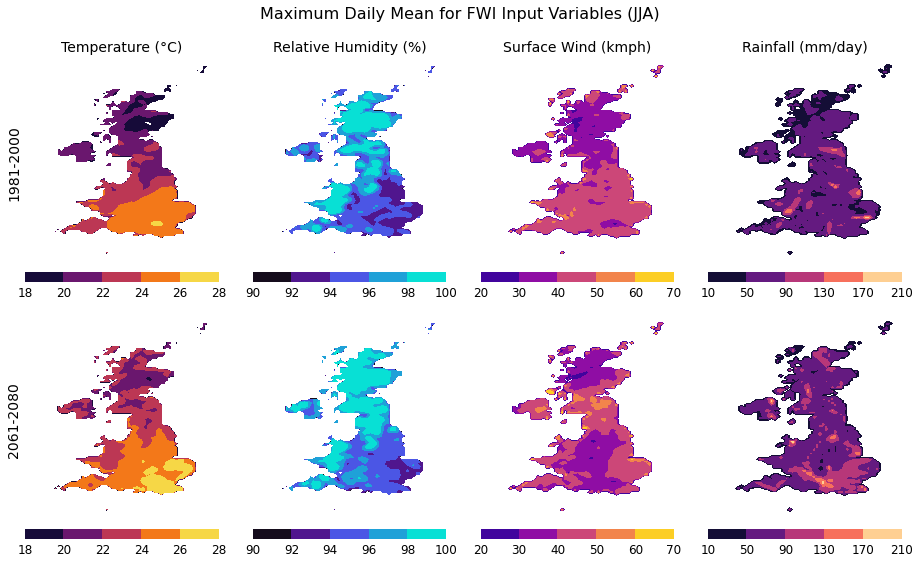

In [159]:
# Max plots:
fig, axs = plt.subplots(2,4)
fig.set_figheight(8)
fig.set_figwidth(13)
fig.suptitle('Maximum Daily Mean for FWI Input Variables (JJA)', fontsize=16)


levels = np.linspace(18, 28, 5+1)
axs[0,0].set_title('Temperature (°C)',fontsize=14)
data00 = (tas_max_80to00*mask)[5:115,20:85]
c00 = axs[0,0].contourf(data00,cmap=plt.get_cmap('inferno'),levels=levels)
axs[0,0].spines['top'].set_visible(False)
axs[0,0].spines['right'].set_visible(False)
axs[0,0].spines['bottom'].set_visible(False)
axs[0,0].spines['left'].set_visible(False)
axs[0,0].get_xaxis().set_ticks([])
axs[0,0].get_yaxis().set_ticks([])
axs[0,0].set_ylabel('1981-2000',fontsize=14)
divider = make_axes_locatable(axs[0,0])
cax = divider.append_axes('bottom', size='5%', pad=0.05)
cb00 = fig.colorbar(c00, cax=cax, orientation='horizontal')
cb00.outline.set_visible(False)
cb00.ax.tick_params(length=0,labelsize=12)
data01 = (tas_max_60to80*mask)[5:115,20:85]
c01 = axs[1,0].contourf(data01,cmap=plt.get_cmap('inferno'),levels=levels)
axs[1,0].spines['top'].set_visible(False)
axs[1,0].spines['right'].set_visible(False)
axs[1,0].spines['bottom'].set_visible(False)
axs[1,0].spines['left'].set_visible(False)
axs[1,0].get_xaxis().set_ticks([])
axs[1,0].get_yaxis().set_ticks([])
axs[1,0].set_ylabel('2061-2080',fontsize=14)
divider = make_axes_locatable(axs[1,0])
cax = divider.append_axes('bottom', size='5%', pad=0.05)
cb01 = fig.colorbar(c01, cax=cax, orientation='horizontal')
cb01.outline.set_visible(False)
cb01.ax.tick_params(length=0,labelsize=12)


levels = np.linspace(90, 100, 5+1)
axs[0,1].set_title('Relative Humidity (%)',fontsize=14)
data10 = (hurs_max_80to00*mask)[5:115,20:85]
c10 = axs[0,1].contourf(data10,cmap=plt.get_cmap('cmr.cosmic'),levels=levels)
axs[0,1].axis('off')
divider = make_axes_locatable(axs[0,1])
cax = divider.append_axes('bottom', size='5%', pad=0.05)
cb10 = fig.colorbar(c10, cax=cax, orientation='horizontal')
cb10.outline.set_visible(False)
cb10.ax.tick_params(length=0,labelsize=12)
data11 = (hurs_max_60to80*mask)[5:115,20:85]
c11 = axs[1,1].contourf(data11,cmap=plt.get_cmap('cmr.cosmic'),levels=levels)
axs[1,1].axis('off')
divider = make_axes_locatable(axs[1,1])
cax = divider.append_axes('bottom', size='5%', pad=0.05)
cb11 = fig.colorbar(c11, cax=cax, orientation='horizontal')
cb11.outline.set_visible(False)
cb11.ax.tick_params(length=0,labelsize=12)


levels = np.linspace(20, 70, 5+1)
axs[0,2].set_title('Surface Wind (kmph)',fontsize=14)
data20 = (wind_max_80to00*mask)[5:115,20:85]
c20 = axs[0,2].contourf(data20,cmap=plt.get_cmap('plasma'),levels=levels)
axs[0,2].axis('off')
divider = make_axes_locatable(axs[0,2])
cax = divider.append_axes('bottom', size='5%', pad=0.05)
cb20 = fig.colorbar(c20, cax=cax, orientation='horizontal')
cb20.outline.set_visible(False)
cb20.ax.tick_params(length=0,labelsize=12)
data21 = (wind_max_60to80*mask)[5:115,20:85]
c21 = axs[1,2].contourf(data21,cmap=plt.get_cmap('plasma'),levels=levels)
axs[1,2].axis('off')
divider = make_axes_locatable(axs[1,2])
cax = divider.append_axes('bottom', size='5%', pad=0.05)
cb21 = fig.colorbar(c21, cax=cax, orientation='horizontal')
cb21.outline.set_visible(False)
cb21.ax.tick_params(length=0,labelsize=12)


levels = np.linspace(10, 210, 5+1)
axs[0,3].set_title('Rainfall (mm/day)',fontsize=14)
data30 = (pr_max_80to00*mask)[5:115,20:85]
c30 = axs[0,3].contourf(data30,cmap=plt.get_cmap('magma'),levels=levels)
axs[0,3].axis('off')
divider = make_axes_locatable(axs[0,3])
cax = divider.append_axes('bottom', size='5%', pad=0.05)
cb30 = fig.colorbar(c30, cax=cax, orientation='horizontal')
cb30.outline.set_visible(False)
cb30.ax.tick_params(length=0,labelsize=12)
data31 = (pr_max_60to80*mask)[5:115,20:85]
c31 = axs[1,3].contourf(data31,cmap=plt.get_cmap('magma'),levels=levels)
axs[1,3].axis('off')
divider = make_axes_locatable(axs[1,3])
cax = divider.append_axes('bottom', size='5%', pad=0.05)
cb31 = fig.colorbar(c31, cax=cax, orientation='horizontal')
cb31.outline.set_visible(False)
cb31.ax.tick_params(length=0,labelsize=12)

plt.tight_layout(pad=1.5)
plt.savefig('/home/theo/images/01_cordex_inputs/input_maps_max')

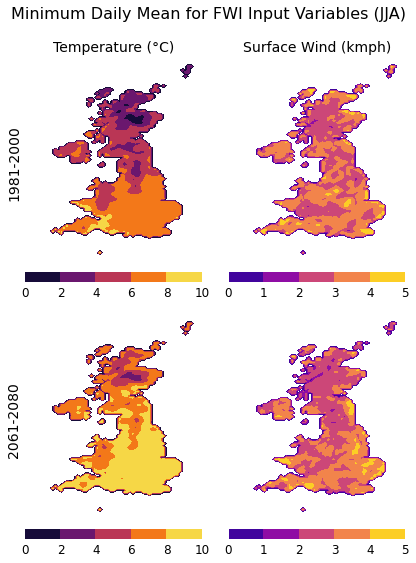

In [176]:
# Min plots:
fig, axs = plt.subplots(2,2)
fig.set_figheight(8)
fig.set_figwidth(6)
fig.suptitle('Minimum Daily Mean for FWI Input Variables (JJA)', fontsize=16)


levels = np.linspace(0.1, 10, 5+1)
axs[0,0].set_title('Temperature (°C)',fontsize=14)
data00 = (tas_min_80to00*mask)[5:115,20:85]
c00 = axs[0,0].contourf(data00,cmap=plt.get_cmap('inferno'),levels=levels)
axs[0,0].spines['top'].set_visible(False)
axs[0,0].spines['right'].set_visible(False)
axs[0,0].spines['bottom'].set_visible(False)
axs[0,0].spines['left'].set_visible(False)
axs[0,0].get_xaxis().set_ticks([])
axs[0,0].get_yaxis().set_ticks([])
axs[0,0].set_ylabel('1981-2000',fontsize=14)
divider = make_axes_locatable(axs[0,0])
cax = divider.append_axes('bottom', size='5%', pad=0.05)
cb00 = fig.colorbar(c00, cax=cax, orientation='horizontal')
cb00.outline.set_visible(False)
cb00.ax.tick_params(length=0,labelsize=12)
cb00.ax.xaxis.set_major_formatter(FormatStrFormatter('%d'))
data01 = (tas_min_60to80*mask)[5:115,20:85]
c01 = axs[1,0].contourf(data01,cmap=plt.get_cmap('inferno'),levels=levels)
axs[1,0].spines['top'].set_visible(False)
axs[1,0].spines['right'].set_visible(False)
axs[1,0].spines['bottom'].set_visible(False)
axs[1,0].spines['left'].set_visible(False)
axs[1,0].get_xaxis().set_ticks([])
axs[1,0].get_yaxis().set_ticks([])
axs[1,0].set_ylabel('2061-2080',fontsize=14)
divider = make_axes_locatable(axs[1,0])
cax = divider.append_axes('bottom', size='5%', pad=0.05)
cb01 = fig.colorbar(c01, cax=cax, orientation='horizontal')
cb01.outline.set_visible(False)
cb01.ax.tick_params(length=0,labelsize=12)
cb01.ax.xaxis.set_major_formatter(FormatStrFormatter('%d'))



levels = np.linspace(0.1, 5, 5+1)
axs[0,1].set_title('Surface Wind (kmph)',fontsize=14)
data20 = (wind_min_80to00*mask)[5:115,20:85]
c20 = axs[0,1].contourf(data20,cmap=plt.get_cmap('plasma'),levels=levels)
axs[0,1].axis('off')
divider = make_axes_locatable(axs[0,1])
cax = divider.append_axes('bottom', size='5%', pad=0.05)
cb20 = fig.colorbar(c20, cax=cax, orientation='horizontal')
cb20.outline.set_visible(False)
cb20.ax.tick_params(length=0,labelsize=12)
cb20.ax.xaxis.set_major_formatter(FormatStrFormatter('%d'))
data21 = (wind_min_60to80*mask)[5:115,20:85]
c21 = axs[1,1].contourf(data21,cmap=plt.get_cmap('plasma'),levels=levels)
axs[1,1].axis('off')
divider = make_axes_locatable(axs[1,1])
cax = divider.append_axes('bottom', size='5%', pad=0.05)
cb21 = fig.colorbar(c21, cax=cax, orientation='horizontal')
cb21.outline.set_visible(False)
cb21.ax.tick_params(length=0,labelsize=12)
cb21.ax.xaxis.set_major_formatter(FormatStrFormatter('%d'))



plt.tight_layout(pad=1.5)
plt.savefig('/home/theo/images/01_cordex_inputs/input_maps_min')

### What is going on with hurs:

In [4]:
directories,tas_files,hurs_files,wind_files,pr_files = get_cordex_addresses()

<class 'list'>


In [9]:
i = 0
hurs_data  = xarray.open_dataset(directories[i] + hurs_files[i], engine = "netcdf4")
years = np.array(pd.to_datetime(np.array(hurs_data.time)).year)
year_inds = np.where(years == 2064)
hurs = np.array(hurs_data.hurs)[year_inds,:,:]
hurs_min = np.min(hurs,axis=0)

In [34]:
min_slice = np.average(np.average(hurs_min,axis=2),axis=1)
mindex = np.amin(min_slice)
print(mindex)
print(directories[i] + hurs_files[i])

0.60479164
/data/met/ukcordex/CNRM-CERFACS-CNRM-CM5/COSMO-crCLIM-v1-1/r1i1p1/dmo/hurs_natgb_CNRM-CERFACS-CNRM-CM5_rcp85_r1i1p1_CLMcom-ETH-COSMO-crCLIM-v1-1_v1_day_19801201-20801130.nc


In [8]:
i = 0
hurs_data  = xarray.open_dataset(directories[i] + hurs_files[i], engine = "netcdf4")
years = np.array(pd.to_datetime(np.array(hurs_data.time)).year)
year_inds = np.where(years == 2064)
hurs = np.array(hurs_data.hurs)[year_inds,:,:]
hurs_min = np.min(hurs,axis=0)
for i in range(len(directories)):
    print(f'Stage {i}')
    hurs_data  = xarray.open_dataset(directories[i] + hurs_files[i], engine = "netcdf4")
    hurs = np.array(hurs_data.hurs)[year_inds,:,:]
    hurs_min = np.min(hurs,axis=0)
    print(np.unique(hurs_min))

Stage 0
[ 0.         0.631957   0.6373732 ... 99.77029   99.77481   99.78868  ]
Stage 1
[ 24.132812  24.429688  24.898438 ... 103.28906  103.39844  104.234375]
Stage 2
[ 39.497845  39.546673  39.5955   ... 100.00701  100.00708  100.017235]
Stage 3
[ 34.237335  34.99524   36.909573 ...  99.94153   99.95928  100.      ]
Stage 4
[35.23959  36.001102 36.3818   ... 99.91321  99.92404  99.94212 ]
Stage 5
[ 30.245745  31.453493  32.598618 ...  99.999985  99.99999  100.      ]
Stage 6
[ 34.41295   36.346878  36.706223 ... 111.837006 113.04175  115.17941 ]
Stage 7
[31.239258 36.58534  37.30217  ... 99.958954 99.96037  99.970856]
Stage 8
[37.240665 37.25885  40.539032 ... 99.873024 99.873474 99.892   ]
Stage 9
[33.622944 33.8503   36.909946 ... 99.894424 99.900055 99.93266 ]
Stage 10
[ 26.03125   26.257812  26.4375   ... 109.34375  109.671875 110.14844 ]
Stage 11
[ 25.793358  26.52578   26.574608 ... 100.00973  100.01886  100.02083 ]
Stage 12
[ 34.98214   35.22628   35.323936 ... 100.01424  100.

In [ ]:
years = np.array(pd.to_datetime(np.array(hurs_data.time)).year)
for year in range(1980,2081,1)
    year_inds = np.where(years <= year)
    